In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import itertools
from tqdm import tqdm
from pylab import *
from PyAstronomy.pyTiming import pyPeriod
#import aplpy

from scipy.optimize import curve_fit
from scipy import odr

import astropy.io.fits as fits
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clip, sigma_clipped_stats, mad_std
from astropy import wcs
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.visualization.mpl_normalize import ImageNormalize

from astroquery.sdss import SDSS
from astroquery.vizier import Vizier

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib.colors import LogNorm
#from matplotlib.patches import Rectangle

#import ccdproc
#from ccdproc import CCDData, Combiner
#from ccdproc import median_filter

from photutils.detection import IRAFStarFinder #DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.datasets import make_100gaussians_image

In [2]:
datadir = '/mnt/data2/ztf/'
path    = os.path.join(datadir, 'ztf_*.fits')
file_list = glob(path)
file_list = sorted(file_list)
len(file_list)

373

file1 = file_list[:318]
file2 = file_list[120:240]
file4 = file_list[240:]

In [29]:
def _rms(flux,flux_model):
    residual = flux-flux_model
    #return np.sqrt((residual**2).sum()/residual.size)
    
    return np.sqrt(np.mean((residual)**2))

def func_lin(p, x):
    a,b = p
    return a*x + b

lin_model = odr.Model(func_lin)

def _linear_reg(xarr,yarr):
    n = len(xarr)
    mu_x = np.average(xarr)
    mu_y = np.average(yarr)
    var_x = np.sum(xarr**2)/n - mu_x**2
    cov_xy = np.sum(xarr*yarr)/n - mu_x*mu_y
    
    slope = cov_xy/var_x
    intercept = mu_y - cov_xy/var_x * mu_x
    return slope, intercept

def _biweight(xarr, yarr, iterations):
    n = 0
    while n < iterations:
        if n == 0:
            #get a and b using unweighted least square --- only first time
            coef = _linear_reg(xarr,yarr)
        else:
            #get a and b using weighted least square
            A = np.zeros((2,2))
            b = np.zeros((2))
            A[0,0] = np.sum(ws * xarr * xarr)
            A[1,0] = np.sum(ws * xarr)
            A[0,1] = A[1,0]
            A[1,1] = np.sum(ws)
            b[0]   = np.sum(ws * xarr * yarr)
            b[1]   = np.sum(ws * yarr)
            
            if LinAlgError:
                coef_lst = np.linalg.lstsq(A, b)
                coef = coef_lst[0]
  
            else:
                coef = np.linalg.solve(A, b)
                


        #calculate weight
        resid = abs(yarr - (coef[0]*xarr + coef[1]))
        const = np.median(resid)*10
        ws = np.zeros(len(xarr))
        for i in range(len(ws)):
            if resid[i] < const:
                ws[i] = (1 - (resid[i]/const)**2)**2
            else:
                ws[i] = 0.
                
        n+=1 
        
    else:
        A = np.zeros((2,2))
        b = np.zeros((2))
        A[0,0] = np.sum(ws * xarr * xarr)
        A[1,0] = np.sum(ws * xarr)
        A[0,1] = A[1,0]
        A[1,1] = np.sum(ws)
        b[0]   = np.sum(ws * xarr * yarr)
        b[1]   = np.sum(ws * yarr)

        if LinAlgError:
            print('singular matrix')
            coef_lst = np.linalg.lstsq(A, b)
            coef = coef_lst[0]
        else:
            coef = np.linalg.solve(A, b)
            
        return coef
    
def _biweight2_withu(xarr, yarr, yerr, iterations):
    n = 0
    while n < iterations:
        if n == 0:
            #get a and b using unweighted least square --- only first time
            coef = _linear_reg(xarr,yarr)
        else:
            #get a and b using weighted least square
            A = np.zeros((2,2))
            b = np.zeros((2))
            A[0,0] = np.sum(ws * xarr * xarr)
            A[1,0] = np.sum(ws * xarr)
            A[0,1] = A[1,0]
            A[1,1] = np.sum(ws)
            b[0]   = np.sum(ws * xarr * yarr)
            b[1]   = np.sum(ws * yarr)
            
            if LinAlgError:
                coef_lst = np.linalg.lstsq(A, b)
                coef = coef_lst[0]
  
            else:
                coef = np.linalg.solve(A, b)
                


        #calculate weight
        resid = abs(yarr - (coef[0]*xarr + coef[1]))
        const = np.median(resid)*10
        ws = np.zeros(len(xarr))
        for i in range(len(ws)):
            if resid[i] < const:
                ws[i] = (1 - (resid[i]/const)**2)**2
            else:
                ws[i] = 0.
                
        n+=1 
        
    else:
        A = np.zeros((2,2))
        b = np.zeros((2))
        A[0,0] = np.sum(ws * xarr * xarr)
        A[1,0] = np.sum(ws * xarr)
        A[0,1] = A[1,0]
        A[1,1] = np.sum(ws)
        b[0]   = np.sum(ws * xarr * yarr)
        b[1]   = np.sum(ws * yarr)

        if LinAlgError:
            print('singular matrix')
            coef_lst = np.linalg.lstsq(A, b)
            coef = coef_lst[0]
            
            nlen = len(xarr)
            x1 = np.sum(xarr)
            x2 = np.sum(xarr**2)
            delta = nlen*x2 - x1**2
            x2uy2 = np.sum((xarr*yerr)**2)
            x1uy2 = np.sum(xarr*yerr**2)
            uy2 = np.sum(yerr**2)
            #sigma_a = 1/delta**2 * (nlen**2*x2uy2 - 2*nlen*x1uy2*x1 + uy2*x1**2)
            #sigma_b = 1/delta**2 * (uy2*x2**2 - 2*x1uy2*x1*x2 + x2uy2*x1**2)
            
            
            sigma_y = np.sqrt(np.sum((coef[0]*xarr+coef[1]-yarr)**2)/(nlen-2))
            sigma_a = sigma_y * np.sqrt(nlen/delta)
            sigma_b = sigma_y * np.sqrt(x2/delta)
                
        else:
            coef = np.linalg.solve(A, b)
            
            #uncertainties
            delta = np.sum(ws)*np.sum(ws*xarr**2) - (np.sum(ws*xarr))**2
            wsum = np.sum(ws)
            w2x2uy2 = np.sum((ws*xarr*yerr)**2)
            w2x1uy2 = np.sum(xarr*(ws*yerr)**2)
            w1x1 = np.sum(ws*xarr)
            w1x2 = np.sum(ws*xarr**2)
            w2uy2 = np.sum((ws*yerr)**2)

            sigma_a = np.sqrt(1/delta**2 * (w2x2uy2*wsum**2 - 2*w2x1uy2*wsum*w1x1 + w2uy2*w1x1**2))
            sigma_b = np.sqrt(1/delta**2 * (w2uy2*w1x1**2 - 2*w2x1uy2*w1x1*w1x2 + w2x2uy2*w1x1**2))

            
        return coef, sigma_a, sigma_b

http://www.cc.u-ryukyu.ac.jp/~fukami/p0.pdf

# Skip below

# ref image setting

In [4]:
hdu_ref = fits.open(file_list[0])
data_ref = hdu_ref[0].data
exp_ref = hdu_ref[0].header['EXPTIME']
wcs_ref = wcs.WCS(hdu_ref[0].header)
mean_ref, med_ref, std_ref = sigma_clipped_stats(data_ref, sigma=3.0)

iraffind = IRAFStarFinder(fwhm=3.0, threshold=100.*std_ref,peakmax=6e4)  
source_ref = iraffind(data_ref - med_ref)  
for col in source_ref.colnames:  
    source_ref[col].info.format = '%.8g'  # for consistent table output

rad=2.5
#phot_ref = source_ref.to_pandas()
##rad = np.median(source_ref['fwhm'])
#rad = np.max(source_ref['fwhm'])
#rad = np.median(source_ref['fwhm'][source_ref['peak']>1e3])
print('rad:', rad)
pos_ref = np.transpose((source_ref['xcentroid'], source_ref['ycentroid']))
rad_ref = CircularAperture(pos_ref, r=rad)#.to_sky(wcs_ref)
annulus_aperture = CircularAnnulus(pos_ref, r_in=6*rad, r_out=7*rad)
annulus_masks = annulus_aperture.to_mask(method='center')
norm = ImageNormalize(stretch=SqrtStretch())

bkg_median = []
for mask in annulus_masks:
    noise = np.sqrt(data_ref)
    annulus_data = mask.multiply(data_ref)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot_ref = aperture_photometry(data_ref, rad_ref, error=noise)
phot_ref['annulus_median'] = bkg_median
phot_ref['aper_bkg'] = bkg_median * rad_ref.area
phot_ref['aper_sum_bkgsub'] = phot_ref['aperture_sum'] - phot_ref['aper_bkg']
for col in phot_ref.colnames:
    phot_ref[col].info.format = '%.8g'  # for consistent table output
phot_ref = phot_ref.to_pandas()




phot_ref['ra'] = np.zeros(len(phot_ref))
phot_ref['dec'] = np.zeros(len(phot_ref))
phot_ref['mag'] = -2.5*np.log10(phot_ref['aperture_sum']/exp_ref)
phot_ref['mag_err'] = 2.5*(phot_ref['aperture_sum_err']/exp_ref)  / (phot_ref['aperture_sum']/exp_ref) / np.log(10) 

for j in range(len(phot_ref)):
    phot_ref['ra'][j],phot_ref['dec'][j]  = wcs_ref.wcs_pix2world([[phot_ref['xcenter'][j], phot_ref['ycenter'][j]]], 0)[0]

rad: 2.5


<ipython-input-4-193eb2cf225e>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phot_ref['ra'][j],phot_ref['dec'][j]  = wcs_ref.wcs_pix2world([[phot_ref['xcenter'][j], phot_ref['ycenter'][j]]], 0)[0]


# separate group photometry

### Need to change 'fileX'

In [6]:
hdu_list    = [[] for _ in range(len(file1))]
data_list   = [[] for _ in range(len(file1))]
exp_list    = [[] for _ in range(len(file1))]
mean_list   = [[] for _ in range(len(file1))]
med_list    = [[] for _ in range(len(file1))]
std_list    = [[] for _ in range(len(file1))]
source_list = [[] for _ in range(len(file1))]
daofind     = [[] for _ in range(len(file1))]
pos_list    = [[] for _ in range(len(file1))]
rad_list    = [[] for _ in range(len(file1))]
wcs_list    = [[] for _ in range(len(file1))]
phot_list   = [[] for _ in range(len(file1))]
phot_df     = [[] for _ in range(len(file1))]

for i in tqdm(range(len(file1))):
    hdu_list[i] = fits.open(file1[i])
    data_list[i] = hdu_list[i][0].data
    exp_list[i] = hdu_list[i][0].header['EXPTIME']
    wcs_list[i] = wcs.WCS(hdu_list[i][0].header)
    mean_list[i], med_list[i], std_list[i] = sigma_clipped_stats(data_list[i], sigma=3.0)
    
    iraffind = IRAFStarFinder(fwhm=3.0, threshold=100.*std_list[i],peakmax=6e4)  
    source_list[i] = iraffind(data_list[i] - med_list[i])  
    for col in source_list[i].colnames:  
        source_list[i][col].info.format = '%.8g'  # for consistent table output
        
    rad = 2.5
    #phot_list[i] = source_list[i].to_pandas()
    ##rad = np.median(source_list[i]['fwhm'])
    #rad = np.max(source_list[i]['fwhm'])
    #rad = np.median(source_list[i]['fwhm'][source_list[i]['peak']>1e3])
    print('rad:', rad)
    pos_list[i] = np.transpose((source_list[i]['xcentroid'], source_list[i]['ycentroid']))
    rad_list[i] = CircularAperture(pos_list[i], r=rad)#.to_sky(wcs_list[i])
    annulus_aperture = CircularAnnulus(pos_list[i], r_in=6*rad, r_out=7*rad)
    annulus_masks = annulus_aperture.to_mask(method='center')
    norm = ImageNormalize(stretch=SqrtStretch())
    
    bkg_median = []
    for mask in annulus_masks:
        noise = np.sqrt(data_list[i])
        annulus_data = mask.multiply(data_list[i])
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
    bkg_median = np.array(bkg_median)
    phot_list[i] = aperture_photometry(data_list[i], rad_list[i], error=noise)
    phot_list[i]['annulus_median'] = bkg_median
    phot_list[i]['aper_bkg'] = bkg_median * rad_list[i].area
    phot_list[i]['aper_sum_bkgsub'] = phot_list[i]['aperture_sum'] - phot_list[i]['aper_bkg']
    for col in phot_list[i].colnames:
        phot_list[i][col].info.format = '%.8g'  # for consistent table output
    phot_df[i] = phot_list[i].to_pandas()

  0%|          | 0/15 [00:00<?, ?it/s]

rad: 2.5


  7%|▋         | 1/15 [00:08<01:52,  8.01s/it]

rad: 2.5


 13%|█▎        | 2/15 [00:15<01:41,  7.84s/it]

rad: 2.5


 20%|██        | 3/15 [00:21<01:24,  7.04s/it]

rad: 2.5


 27%|██▋       | 4/15 [00:38<02:00, 10.92s/it]

rad: 2.5


 33%|███▎      | 5/15 [00:57<02:18, 13.88s/it]

rad: 2.5


 47%|████▋     | 7/15 [01:12<01:19,  9.93s/it]

rad: 2.5
rad: 2.5


 53%|█████▎    | 8/15 [01:22<01:08,  9.77s/it]

rad: 2.5


 60%|██████    | 9/15 [01:34<01:03, 10.62s/it]

rad: 2.5


 67%|██████▋   | 10/15 [01:47<00:55, 11.19s/it]

rad: 2.5


 73%|███████▎  | 11/15 [02:07<00:55, 13.82s/it]

rad: 2.5


 80%|████████  | 12/15 [02:21<00:42, 14.09s/it]

rad: 2.5


 87%|████████▋ | 13/15 [02:40<00:31, 15.63s/it]

rad: 2.5


 93%|█████████▎| 14/15 [03:04<00:17, 17.95s/it]

rad: 2.5


100%|██████████| 15/15 [03:21<00:00, 13.46s/it]


In [8]:
for i in tqdm(range(len(phot_df))):
    phot_df[i]['ra'] = np.zeros(len(phot_df[i]))
    phot_df[i]['dec'] = np.zeros(len(phot_df[i]))
    phot_df[i]['mag'] = -2.5*np.log10(phot_df[i]['aperture_sum']/exp_list[i])
    phot_df[i]['mag_err'] = 2.5*(phot_df[i]['aperture_sum_err']/exp_list[i])  / (phot_df[i]['aperture_sum']/exp_list[i]) / np.log(10) 
    
    for j in range(len(phot_df[i])):
        phot_df[i]['ra'][j],phot_df[i]['dec'][j]  = wcs_list[i].wcs_pix2world([[phot_df[i]['xcenter'][j], phot_df[i]['ycenter'][j]]], 0)[0]

  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-8-fbbb5194b42d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phot_df[i]['ra'][j],phot_df[i]['dec'][j]  = wcs_list[i].wcs_pix2world([[phot_df[i]['xcenter'][j], phot_df[i]['ycenter'][j]]], 0)[0]
100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


for i in range(len(phot_df)):
    phot_df[i].to_csv('/mnt/data2/ztf/wasp80_phot/waspWASP80_phot_{}.csv'.format(i), index=False)

In [18]:
1*3*4

12

# Without photometry

In [4]:
hdu_list    = [[] for _ in range(len(file_list))]
data_list   = [[] for _ in range(len(file_list))]
exp_list    = [[] for _ in range(len(file_list))]
phot_df   = [[] for _ in range(len(file_list))]


for i in tqdm(range(len(file_list))):
    hdu_list[i] = fits.open(file_list[i])
    data_list[i] = hdu_list[i][0].data
    exp_list[i] = hdu_list[i][0].header['EXPTIME']
    phot_df[i] = pd.read_csv('/mnt/data2/ztf/wasp80_phot/waspWASP80_phot_{}.csv'.format(i))
    
phot_ref = phot_df[0]

100%|██████████| 373/373 [00:02<00:00, 132.26it/s]


In [5]:
coo_ims = []
idxs = []
d2ds = []
d3ds = []
sep_constraints = []

mask=(phot_ref['mag']<-10.0) 
phot_cut_df0 = phot_ref[mask] 
coo_ref = SkyCoord(ra=phot_cut_df0['ra']*u.degree, dec=phot_cut_df0['dec']*u.degree)


for i in tqdm(range(len(phot_df))):
    
    coo_im = SkyCoord(ra=phot_df[i]['ra']*u.degree, dec=phot_df[i]['dec']*u.degree)
    coo_ims.append(coo_im)

    idx, d2d, d3d = coo_ims[i].match_to_catalog_sky(coo_ref)
    idxs.append(idx)
    d2ds.append(d2d)
    d3ds.append(d3d)

    max_sep = 0.9*u.arcsec
    sep_constraint = d2ds[i] < max_sep
    sep_constraints.append(sep_constraint)
    #coo_m3_matches = coo_m3s[i][sep_constraints[i]]
    #coo_ref_matches = coo_ref[idxs[i][sep_constraints[i]]]

100%|██████████| 373/373 [00:15<00:00, 23.48it/s]


In [6]:
target = []

for i in range(len(phot_df)):
    tid = phot_df[i][(phot_df[i]['dec']>-2.145) & (phot_df[i]['dec']<-2.14) & (phot_df[i]['ra']>303.166) & (phot_df[i]['ra']<303.168)].index
    if len(tid)==1:
        target.append(tid)
    else:
        target.append('None')


389/スキップ
0
yerr: 0.046223903877052726
y_dash_err: 0.06537047176875825
singular matrix
a; 0.0
b; 0.0


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


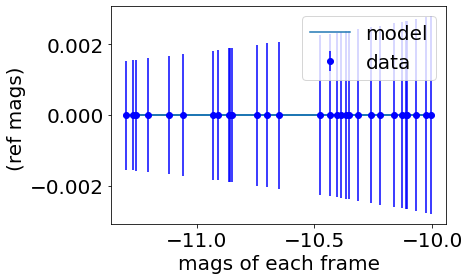

336/スキップ
1
yerr: 0.028681301114359
y_dash_err: 0.038913091695198014
singular matrix
a; 0.021106639417441446
b; 0.4188101756892922


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


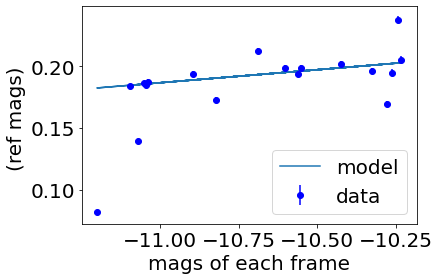

223/スキップ
2
yerr: 0.018292788060799235
y_dash_err: 0.0284965128273729
singular matrix
a; -0.033558689105169195
b; -0.7205522366839578


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


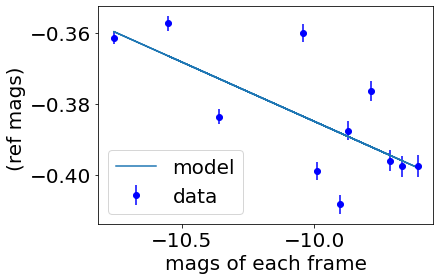

1029/スキップ
3
yerr: 0.031241756139082737
y_dash_err: 0.040946555803229784
singular matrix
a; 0.04687635599567237
b; 0.8632306973197214


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


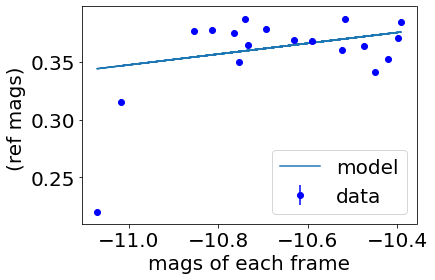

4
yerr: 0.03242372188873989
y_dash_err: 0.04217943151947148
singular matrix
a; 0.1581881582039031
b; 2.093950660351331


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


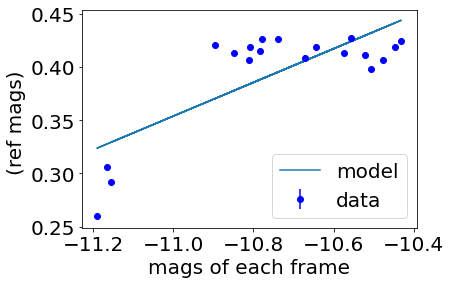

689/スキップ
5
yerr: 0.04291892521976251
y_dash_err: 0.06249215329615292
singular matrix
a; 0.02066270394744155
b; 0.08991264136147922


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


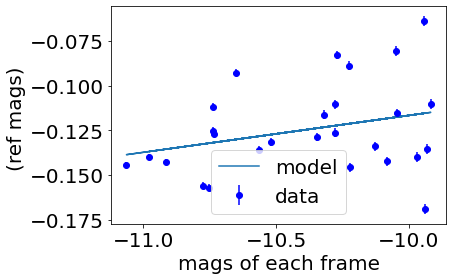

6
yerr: 0.01047266406609668
y_dash_err: 0.014853928708377673
502/スキップ
7
yerr: 0.035300781668085666
y_dash_err: 0.04644447541300311


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.05966716171933251
b; 0.9867675858131577


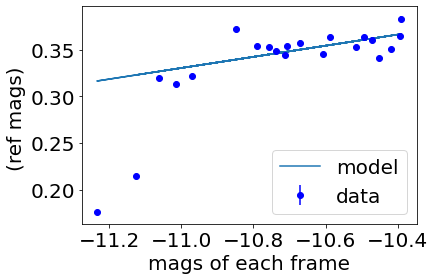

716/スキップ
8
yerr: 0.017980812108343402
y_dash_err: 0.02287861626226758
singular matrix
a; 0.2623983839165131
b; 3.3355975459205625


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


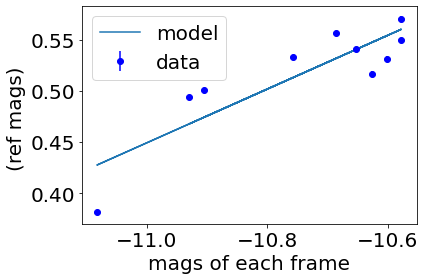

9
yerr: 0.020113381676202507
y_dash_err: 0.02594597394331191
singular matrix
a; 0.0867251779595735
b; 1.3641830216012958


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


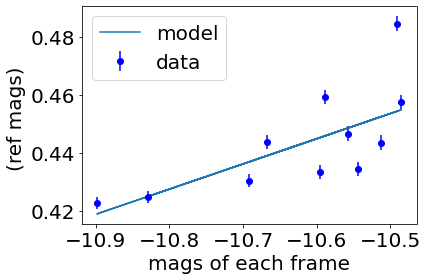

10
yerr: 0.02519924197898483
y_dash_err: 0.03265656574049165
singular matrix
a; 0.012575961984111107
b; 0.5506119175232939


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


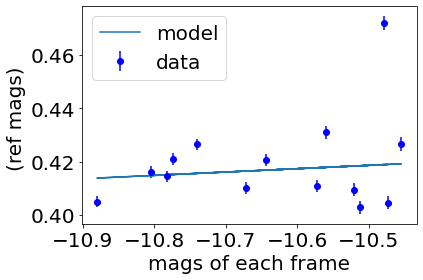

882/スキップ
11
yerr: 0.03532965568056504
y_dash_err: 0.04736193779878356
singular matrix
a; 0.010976702311129252
b; 0.3665252742103932


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


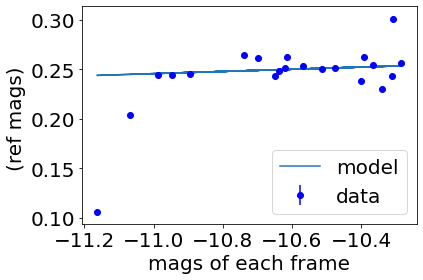

1163/スキップ
12
yerr: 0.029520152101705003
y_dash_err: 0.03818638447356048


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.0030260925139163064
b; 0.4770863661846096


<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


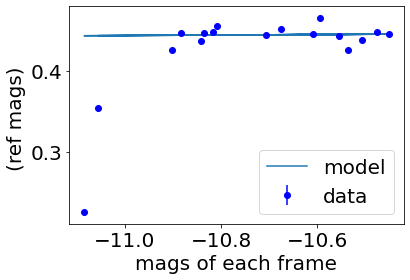

13
yerr: 0.025147991416449984
y_dash_err: 0.032770497500954496
singular matrix
a; -0.018006841395743996
b; 0.19915225360808597


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


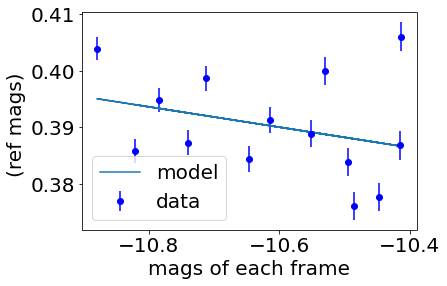

14
yerr: 0.026874108202132076
y_dash_err: 0.03462926046475977
singular matrix
a; 0.05178115768553249
b; 1.0030852755041826


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


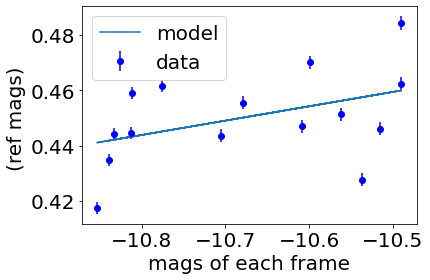

15
yerr: 0.029671516277659453
y_dash_err: 0.038339989848759345
singular matrix
a; 0.12978117899639374
b; 1.8251794260647392


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


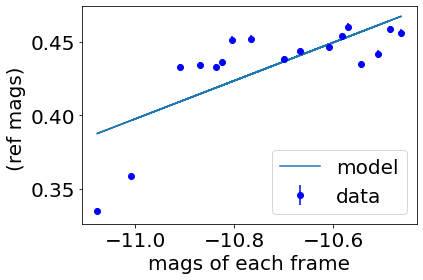

347/スキップ
16
yerr: 0.03238944366954672
y_dash_err: 0.042565262221897056
singular matrix
a; 0.2396151432865843
b; 2.901714679801389


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


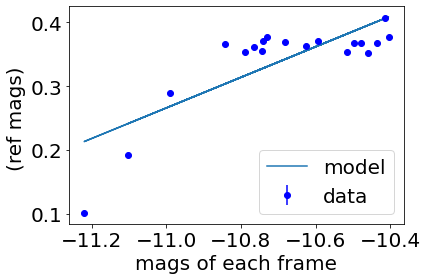

17
yerr: 0.019702916768458475
y_dash_err: 0.025338725728251695
singular matrix
a; 0.23001480271194913
b; 2.9168699252263095


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


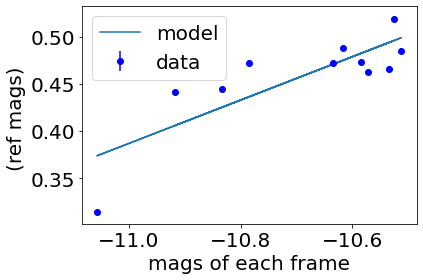

1064/スキップ
18
yerr: 0.014037134114625312
y_dash_err: 0.018261285839634822
149/スキップ
19
yerr: 0.02051566593941132
y_dash_err: 0.028855355020377792
singular matrix
a; 0.018485984036919284
b; 0.21806875623837554


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


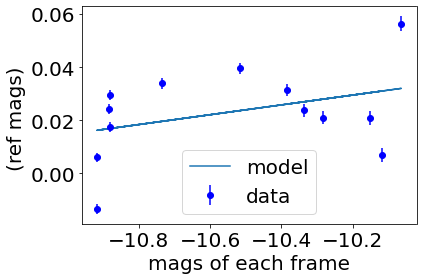

544/スキップ
20
yerr: 0.038713074125729795
y_dash_err: 0.055303031422260215
singular matrix
a; 0.04097844135596794
b; 0.3824459429348057


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


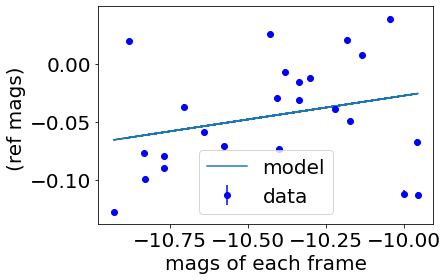

21
yerr: 0.007738582835511733
y_dash_err: 0.009886118267825091
631/スキップ
22
yerr: 0.017713538429185913
y_dash_err: 0.02263963892827796
singular matrix
a; 0.32143115873978517
b; 3.946561394026725


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


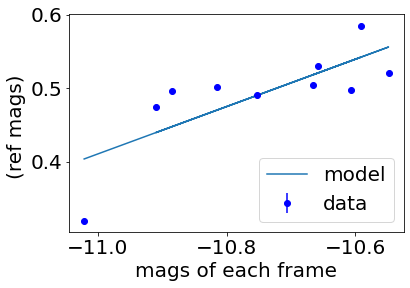

23
yerr: 0.003764611155150006
y_dash_err: 0.004793940750632336
24
yerr: 0.019966253556401598
y_dash_err: 0.025819333015208293
singular matrix
a; 0.021992402258540888
b; 0.6646866620721585


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


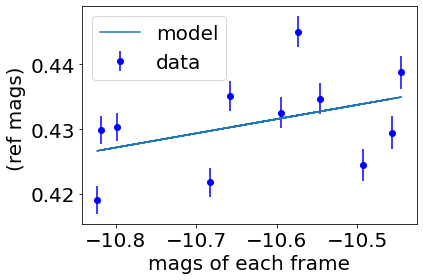

25
yerr: 0.019972027060554898
y_dash_err: 0.02624493501599215
singular matrix
a; 0.3811647959412226
b; 4.430012152132139


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


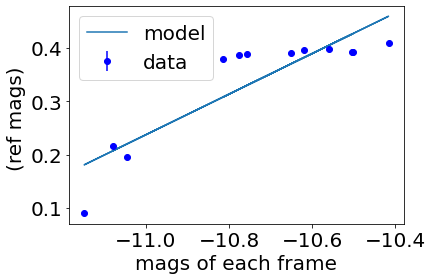

26
yerr: 0.0297227668401943
y_dash_err: 0.03942370438724047
singular matrix
a; 0.04693336750154866
b; 0.7963210777592802


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


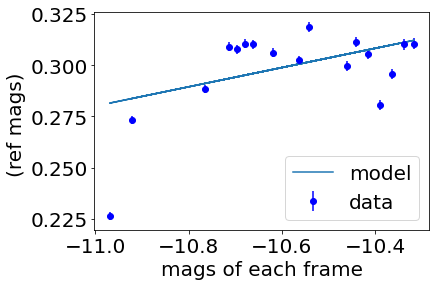

27
yerr: 0.010882759755169568
y_dash_err: 0.014150801280701383
28
yerr: 0.013202291699531282
y_dash_err: 0.016765455535820054
29
yerr: 0.023515715919224054
y_dash_err: 0.02982042236160192
singular matrix
a; 0.13544045284001843
b; 1.9948919955763287


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


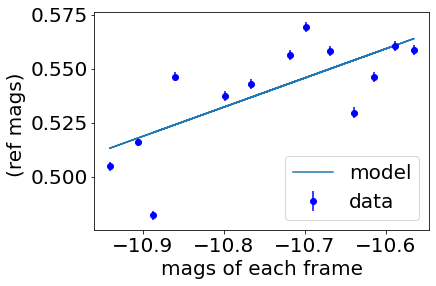

30
yerr: 0.021414347542843815
y_dash_err: 0.027446100204676
singular matrix
a; 0.21781141728017503
b; 2.8155710107499283


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


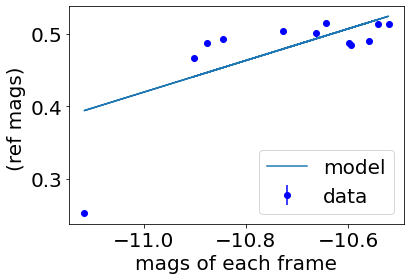

31
yerr: 0.03342644771145501
y_dash_err: 0.04408877920735516
singular matrix
a; 0.1798425113135269
b; 2.250366626633065


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


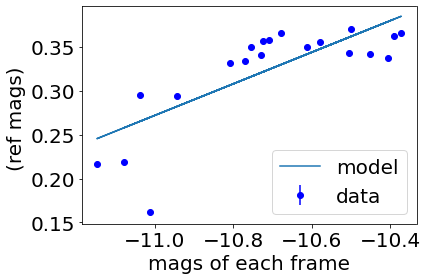

32
yerr: 0.016102925793962483
y_dash_err: 0.02066130155883309
1393/スキップ
33
yerr: 0.014610464155147286
y_dash_err: 0.018729194821642113
34
yerr: 0.030442936239505173
y_dash_err: 0.04057108453597121
singular matrix
a; 0.12057308042358467
b; 1.5740557887963127


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


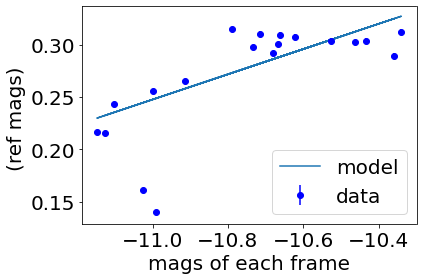

950/スキップ
35
yerr: 0.035086515131722125
y_dash_err: 0.046438249487076866
singular matrix
a; 0.1338251771262826
b; 1.737310194988782


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


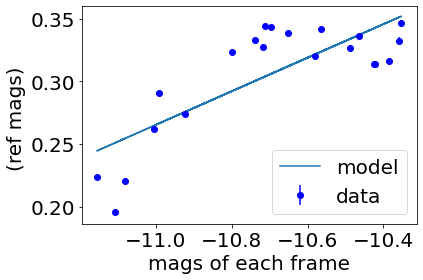

36
yerr: 0.029223278070139445
y_dash_err: 0.037592949703051264
singular matrix
a; 0.2767494298887617
b; 3.437609353831878


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


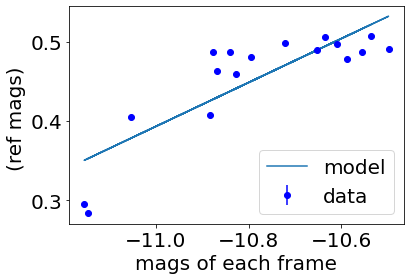

37
yerr: 0.023280137461804105
y_dash_err: 0.03042667292677813
singular matrix
a; 0.010883498418046205
b; 0.48987185951654494


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


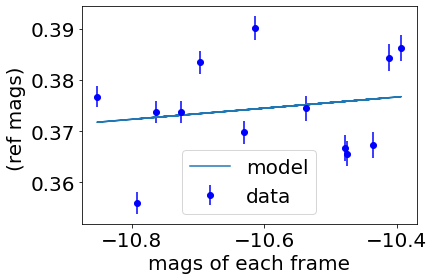

38
yerr: 0.00756939943051296
y_dash_err: 0.009522744943304686
39
yerr: 0.0185210442150902
y_dash_err: 0.02356599654695549
singular matrix
a; 0.12705004203686007
b; 1.8758688783455872


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


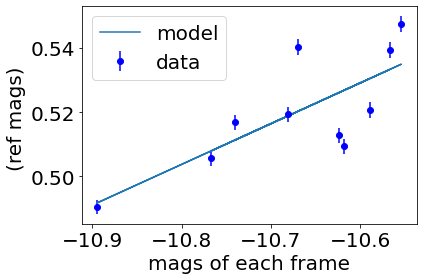

40
yerr: 0.014986742309298457
y_dash_err: 0.019062075066550492
41
yerr: 0.01813380251989609
y_dash_err: 0.023258238081542357
singular matrix
a; 0.05668817273081826
b; 1.0808422175895878


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


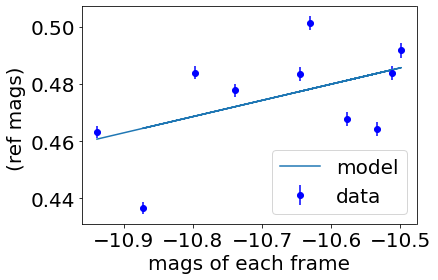

42
yerr: 0.014288125774662357
y_dash_err: 0.018527399939920072
43
yerr: 0.0036302230765583297
y_dash_err: 0.0048788411689252974
666/スキップ
44
yerr: 0.03804621725597146
y_dash_err: 0.05056136493093902
singular matrix
a; 0.11024030165532893
b; 1.4653540330205836


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


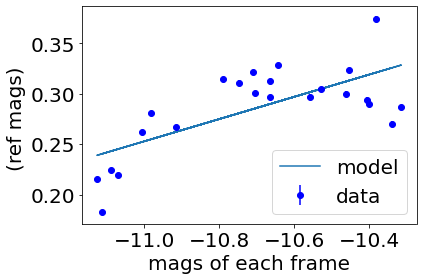

887/スキップ
45
yerr: 0.035454045097755044
y_dash_err: 0.046167012192158394


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.23382061435288493
b; 2.9039754938729816


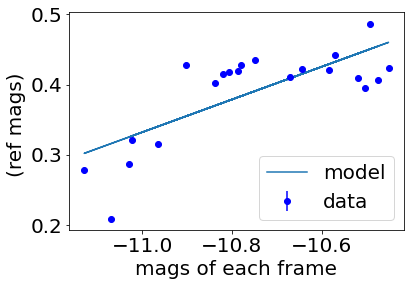

781/スキップ
46
yerr: 0.03137188334243175
y_dash_err: 0.04152766586558919
singular matrix
a; 0.08822128089106047
b; 1.2469946679369908


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


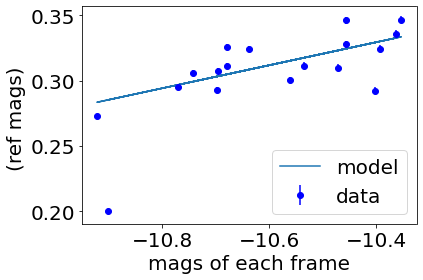

440/スキップ
47
yerr: 0.04400941561163295
y_dash_err: 0.07118493135882559
singular matrix
a; 0.023031344390179124
b; -0.2924741184436319


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


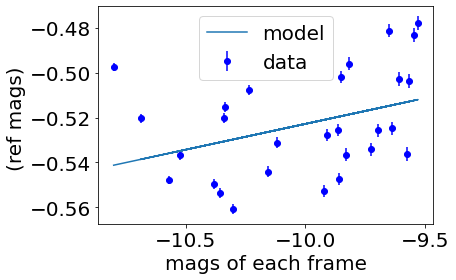

160/スキップ
48
yerr: 0.04511329878485732
y_dash_err: 0.08343234393084543
singular matrix
a; 0.07427949255812108
b; -0.25207338018505154


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


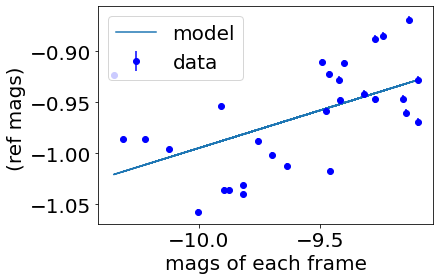

823/スキップ
49
yerr: 0.029391097595991882
y_dash_err: 0.03903666728768592
singular matrix
a; 0.0662880821247313
b; 0.996411009935625


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


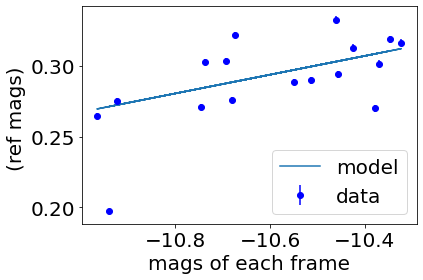

50
yerr: 0.028466445663244383
y_dash_err: 0.03686127784137739
singular matrix
a; -0.0034660884021427626
b; 0.3870429320097957


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


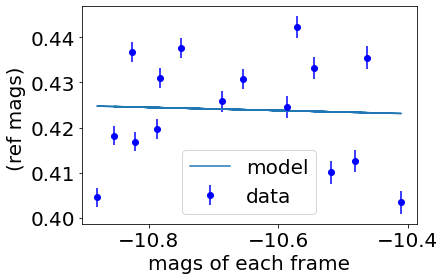

51
yerr: 0.02179995115904479
y_dash_err: 0.02796926966971384
singular matrix
a; 0.05168730724450374
b; 1.024858162263964


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


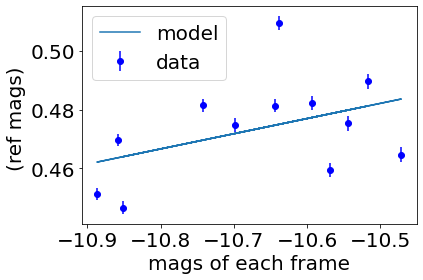

542/スキップ
52
yerr: 0.04059802229090783
y_dash_err: 0.054573655610382674
singular matrix
a; 0.08685425306591092
b; 1.1584324100694416


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


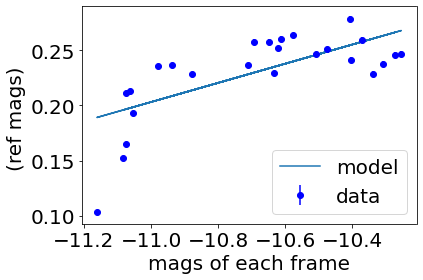

465/スキップ
53
yerr: 0.03938034237609964
y_dash_err: 0.05332973274227287
singular matrix
a; 0.003923049545361308
b; 0.23891229614063725


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


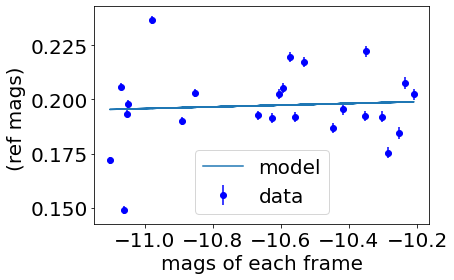

54
yerr: 0.03531974025754908
y_dash_err: 0.048104201237172
singular matrix
a; 0.03513540169010178
b; 0.5407244688755418


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


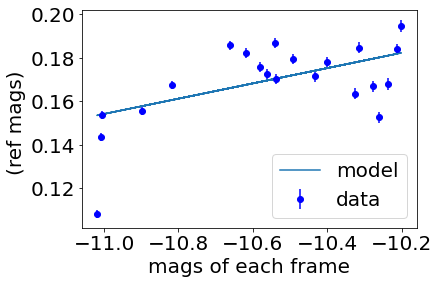

122/スキップ
55
yerr: 0.04511329878485732
y_dash_err: 0.06998396958249448
singular matrix
a; 0.03452321612440962
b; -0.027171752865578696


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


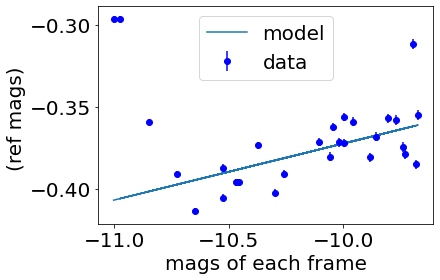

56
yerr: 0.007645797235776273
y_dash_err: 0.009996963329621899
201/スキップ
57
yerr: 0.04503939812223936
y_dash_err: 0.06331779834650761
singular matrix
a; 0.06700993511476927
b; 0.7302940439657373


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


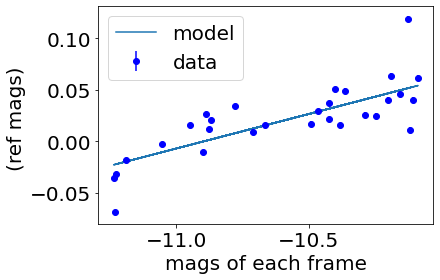

341/スキップ
58
yerr: 0.04056484813091301
y_dash_err: 0.05504952624920944
singular matrix
a; 0.028091788801034655
b; 0.48602088869247556


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


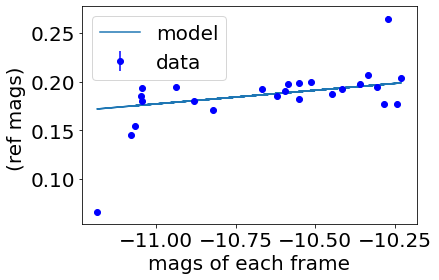

338/スキップ
59
yerr: 0.042886411218945576
y_dash_err: 0.05882922709323748
singular matrix
a; 0.04627513805703222
b; 0.6306586023432855


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


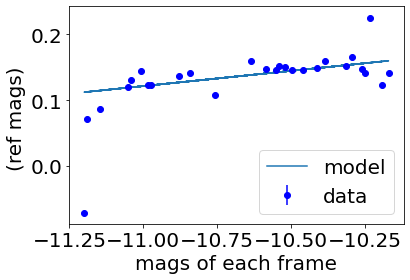

244/スキップ
60
yerr: 0.043983623529787054
y_dash_err: 0.062157927370206874
singular matrix
a; 0.06760258832734212
b; 0.7113551554933403


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


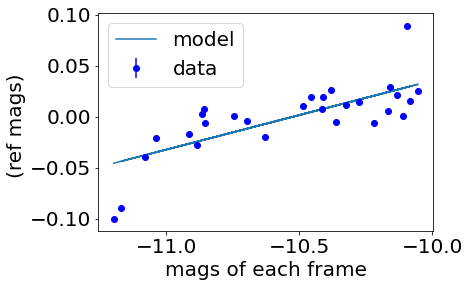

61
yerr: 0.021922108034048433
y_dash_err: 0.02810140492133866
singular matrix
a; -0.07860804840510091
b; -0.36475798564536727


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


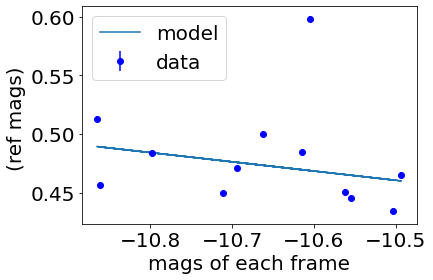

676/スキップ
62
yerr: 0.02990179174175608
y_dash_err: 0.03897261218543743
singular matrix
a; 0.020806030897868755
b; 0.6115878645651891


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


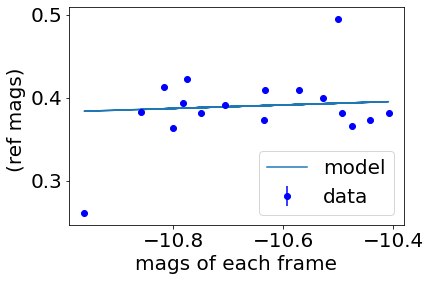

589/スキップ
63
yerr: 0.03137188334243175
y_dash_err: 0.041287232299345965
singular matrix
a; -0.007917169550874419
b; 0.25231764106870636


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


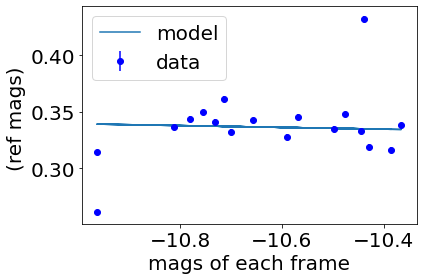

236/スキップ
64
yerr: 0.03736497399081048
y_dash_err: 0.05066896945495469
singular matrix
a; 0.1267954853329546
b; 1.5363681217805616


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


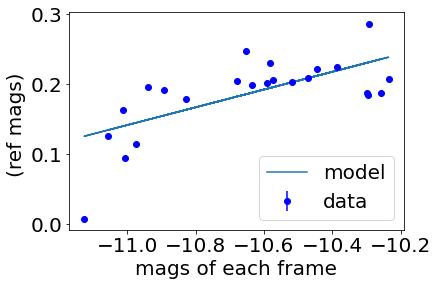

65
yerr: 0.023483477218805567
y_dash_err: 0.0303503666237823
singular matrix
a; 0.05279945176773312
b; 0.9965957027092455


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


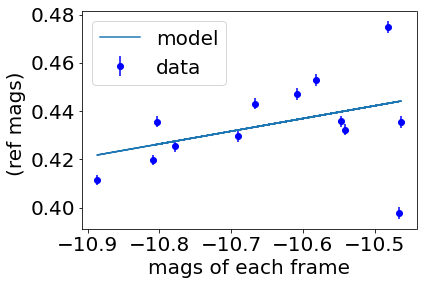

66
yerr: 0.023515715919224054
y_dash_err: 0.030558105619962014
singular matrix
a; 0.01270558791013908
b; 0.5391869764693973


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


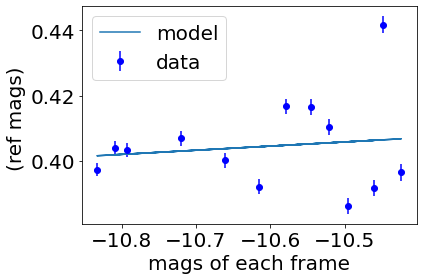

67
yerr: 0.03250561321835016
y_dash_err: 0.04243963843978236
singular matrix
a; 0.229865420911304
b; 2.8416084816204528


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


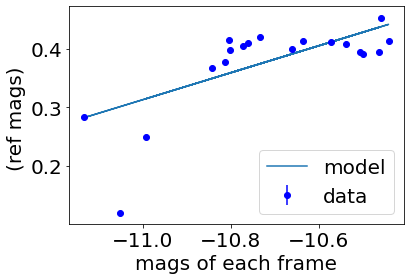

68
yerr: 0.028263444039791006
y_dash_err: 0.036897227523223455
singular matrix
a; -0.003999164063549219
b; 0.34340699906770483


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


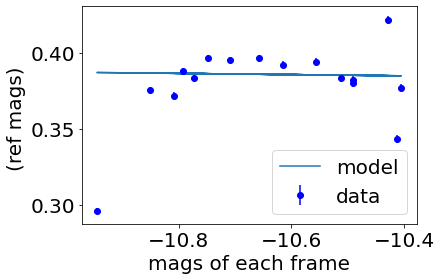

69
yerr: 0.009233178035153191
y_dash_err: 0.011855312896878868
70
yerr: 0.01659271562131863
y_dash_err: 0.021281319397038572
71
yerr: 0.02331848443287136
y_dash_err: 0.03021844980404767
singular matrix
a; 0.0429833795478047
b; 0.8768685530394197


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


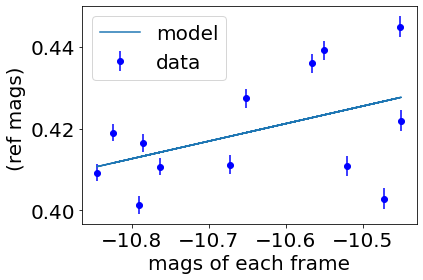

72
yerr: 0.028049673616065245
y_dash_err: 0.036415820458831474
singular matrix
a; 0.20457854629044822
b; 2.5934217672795676


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


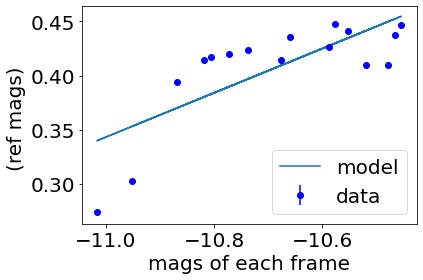

73
yerr: 0.0
y_dash_err: 0.0
21/スキップ
74
yerr: 0.04511329878485732
y_dash_err: 0.07320833860029421
singular matrix
a; 0.19965800504843592
b; 1.4561944202506392


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


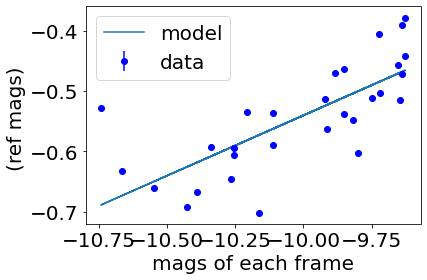

112/スキップ
75
yerr: 0.04291892521976251
y_dash_err: 0.06244149401907271
singular matrix
a; 0.09845060171925947
b; 0.8972632945760065


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


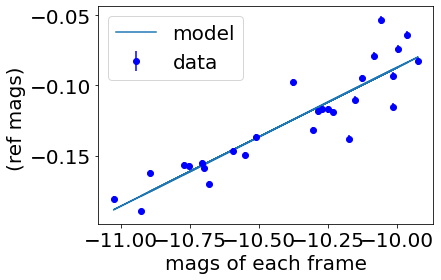

81/スキップ
76
yerr: 0.04511329878485732
y_dash_err: 0.07184521168803543
singular matrix
a; 0.23181880455753773
b; 1.856747785475152


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


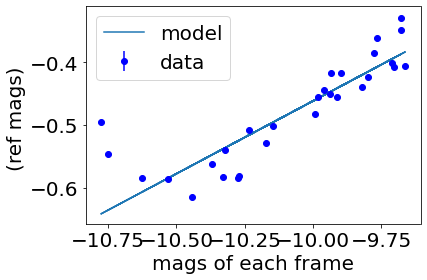

77
yerr: 0.039162676212396136
y_dash_err: 0.05247324444741173
singular matrix
a; 0.09415058303440574
b; 1.2521349454488517


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


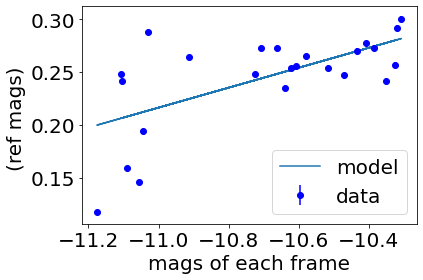

165/スキップ
78
yerr: 0.04173441946494914
y_dash_err: 0.05878148940224448
singular matrix
a; 0.05862249064584532
b; 0.6299045077352483


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


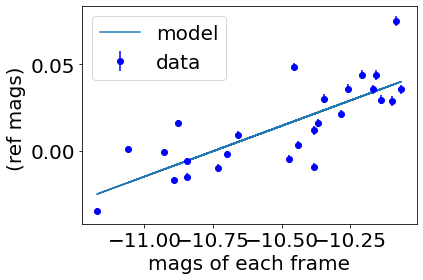

229/スキップ
79
yerr: 0.03922488373358635
y_dash_err: 0.05330170019328391
singular matrix
a; 0.08276213887456783
b; 1.056809035000921


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


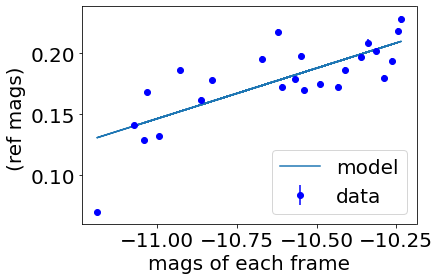

80
yerr: 0.01231983542753048
y_dash_err: 0.015932819751272323
81
yerr: 0.02352614875485578
y_dash_err: 0.030210290164818875
singular matrix
a; 0.08947166476475756
b; 1.4205838346162205


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


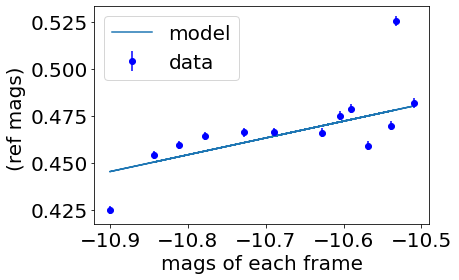

82
yerr: 0.031208643021241014
y_dash_err: 0.04045718882804215
singular matrix
a; 0.21377390444349406
b; 2.705816115070796


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


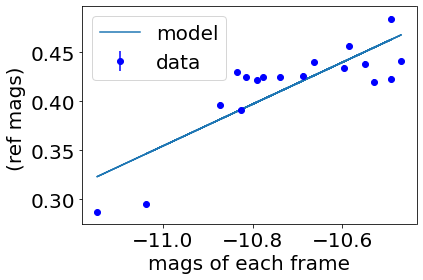

83
yerr: 0.026781146604465414
y_dash_err: 0.034550068203466136
singular matrix
a; 0.08765216987971787
b; 1.3791150017771598


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


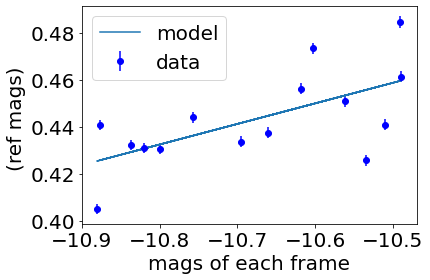

141/スキップ
84
yerr: 0.03807719620312237
y_dash_err: 0.05076570367332576
singular matrix
a; 0.1436083956085352
b; 1.8024401566658306


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


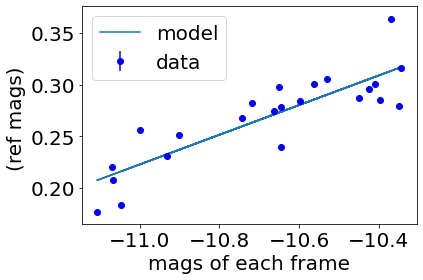

85
yerr: 0.032678734621916686
y_dash_err: 0.04303767439615935
singular matrix
a; 0.0847203331643994
b; 1.2386870579248561


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


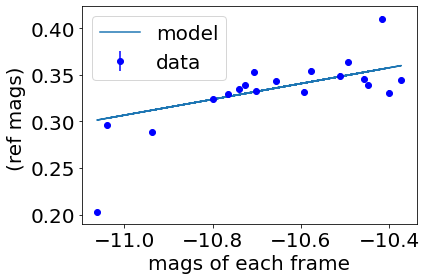

227/スキップ
86
yerr: 0.038089211456188966
y_dash_err: 0.050475241541111625
singular matrix
a; 0.149441910635995
b; 1.8995951909514868


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


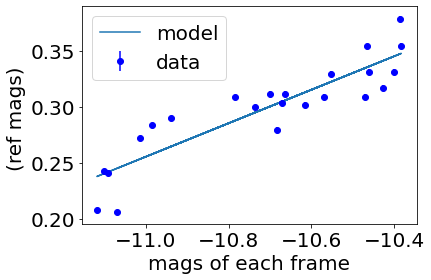

204/スキップ
87
yerr: 0.03387692249751666
y_dash_err: 0.04505423217545411
singular matrix
a; 0.11632710020393391
b; 1.5213398539610457


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


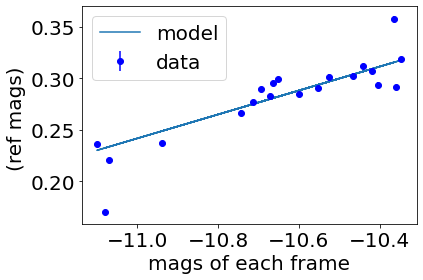

12/スキップ
88
yerr: 0.008264265536281394
y_dash_err: 0.010595645687811227
89
yerr: 0.018396687222087295
y_dash_err: 0.023535851979024126
singular matrix
a; 0.15795904091056368
b; 2.1711818759816683


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


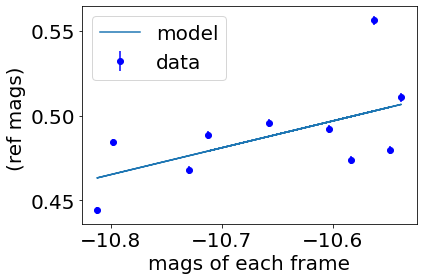

90
yerr: 0.023595201258177486
y_dash_err: 0.030330433809813165
singular matrix
a; 0.07608470256474269
b; 1.2691816782656116


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


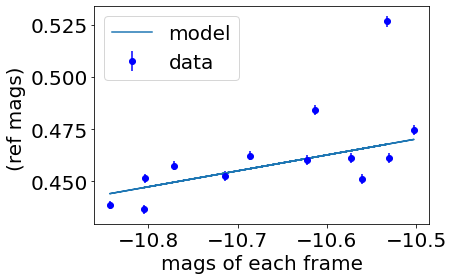

91
yerr: 0.027763037953958465
y_dash_err: 0.036112707067249984
singular matrix
a; 0.2668025739118683
b; 3.24961537994297


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


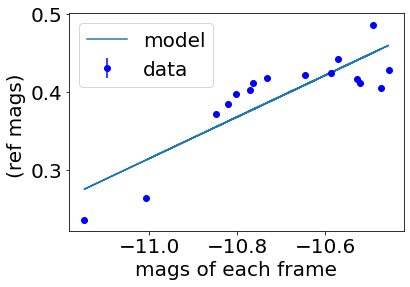

89/スキップ
92
yerr: 0.041653107369099135
y_dash_err: 0.12091099518248179
singular matrix
a; 0.1380436784699386
b; -1.0280197859088025


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


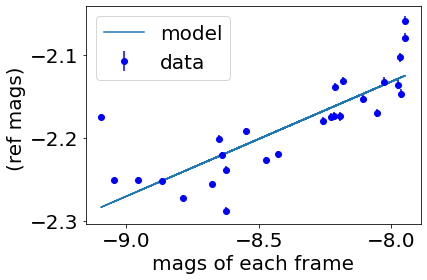

641/スキップ
93
yerr: 0.03785792986758274
y_dash_err: 0.051367176703071685
singular matrix
a; 0.07150062095161558
b; 0.946770521637151


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


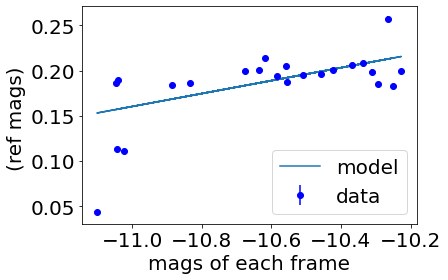

288/スキップ
94
yerr: 0.042893133137916616
y_dash_err: 0.058598366907502086
singular matrix
a; 0.07257194986217728
b; 0.9367887292875756


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


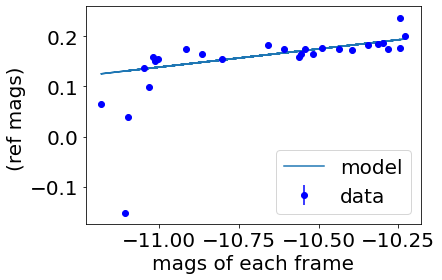

511/スキップ
95
yerr: 0.03203263755945851
y_dash_err: 0.043208255907256174
singular matrix
a; 0.10387819836611899
b; 1.3140054402434906


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


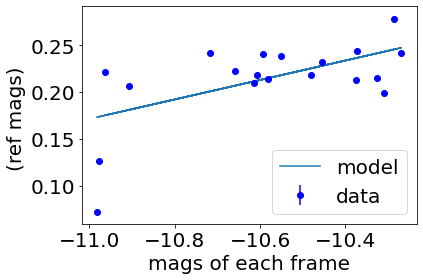

96
yerr: 0.013175118076635592
y_dash_err: 0.017162975786840333
97
yerr: 0.009202215453467858
y_dash_err: 0.011886579464604887
98
yerr: 0.0
y_dash_err: 0.0
99
yerr: 0.0
y_dash_err: 0.0
100
yerr: 0.026781146604465414
y_dash_err: 0.0347325598143848
singular matrix
a; 0.006206400720340917
b; 0.48126483091201083


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


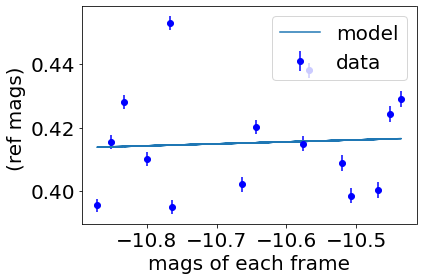

101
yerr: 0.010726891528846424
y_dash_err: 0.013941751142451954
413/スキップ
102
yerr: 0.010894535989023743
y_dash_err: 0.01396711794788526
103
yerr: 0.0106658950253855
y_dash_err: 0.01390350152214374
104
yerr: 0.0
y_dash_err: 0.0
105
yerr: 0.0
y_dash_err: 0.0
106
yerr: 0.009307942461281873
y_dash_err: 0.012045640715759497
107
yerr: 0.010144907764529226
y_dash_err: 0.013146802712156232
108
yerr: 0.014890882836814855
y_dash_err: 0.019209469631772225
109
yerr: 0.012396733483499605
y_dash_err: 0.01605992967339486
110
yerr: 0.0032654306852413608
y_dash_err: 0.004229379791540823
111
yerr: 0.011102691891699032
y_dash_err: 0.01439017848078043
112
yerr: 0.011249306931025698
y_dash_err: 0.014844416461480856
113
yerr: 0.008805206231060046
y_dash_err: 0.011511762897074588
114
yerr: 0.014680593833244899
y_dash_err: 0.019030411207717216
115
yerr: 0.005381873542314533
y_dash_err: 0.006978111303701939
1158/スキップ
116
yerr: 0.010894535989023743
y_dash_err: 0.014143223271258677
1242/スキップ
117
yerr: 0.02485586

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


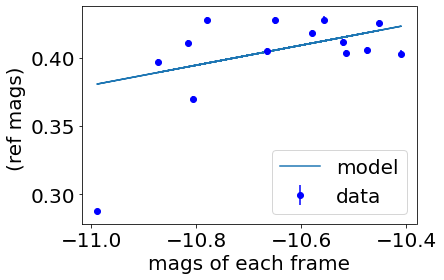

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


118
yerr: 0.005818245845041787
y_dash_err: 0.007530968383792266
119
yerr: 0.009569482027386677
y_dash_err: 0.01243033004171863
120
yerr: 0.012722818615836717
y_dash_err: 0.016537837071056355
121
yerr: 0.008786337811044582
y_dash_err: 0.011405564434912453
122
yerr: 0.01454845066306619
y_dash_err: 0.018876729721799657
123
yerr: 0.006899846151878427
y_dash_err: 0.008967967274489456
124
yerr: 0.0
y_dash_err: 0.0
125
yerr: 0.009401864559866933
y_dash_err: 0.012205893935098026
126
yerr: 0.005381871456619874
y_dash_err: 0.006990304711616381
127
yerr: 0.02510805338033636
y_dash_err: 0.03257724484264285
singular matrix
a; -0.0005489604913654339
b; 0.4074503499641038


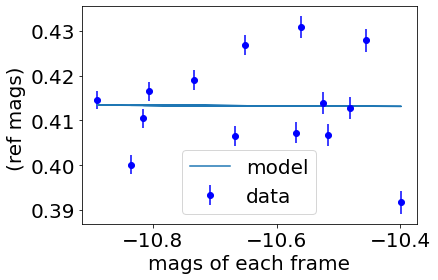

128
yerr: 0.01320558377803589
y_dash_err: 0.0170969638273503
129
yerr: 0.011322201550336879
y_dash_err: 0.014651250024837494
130
yerr: 0.007234450373225973
y_dash_err: 0.009409711655026961
131
yerr: 0.009459189910512047
y_dash_err: 0.012300685102316028
132
yerr: 0.011322201550336879
y_dash_err: 0.014673901951362483
133
yerr: 0.005557842777786581
y_dash_err: 0.007195689984047493
134
yerr: 0.005468566880003184
y_dash_err: 0.00706532031440632
135
yerr: 0.005380528406228132
y_dash_err: 0.006966387202138602
136
yerr:

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


 0.0
y_dash_err: 0.0
137
yerr: 0.0
y_dash_err: 0.0
26/スキップ
138
yerr: 0.022427546883117398
y_dash_err: 0.028652706693428526
singular matrix
a; -0.17445000917809456
b; -1.3706291299087072


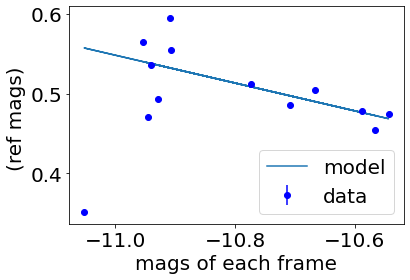

139
yerr: 0.024844916813144567
y_dash_err: 0.03181039844015588
singular matrix
a; 0.0177133329107627
b; 0.6753401099575779


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


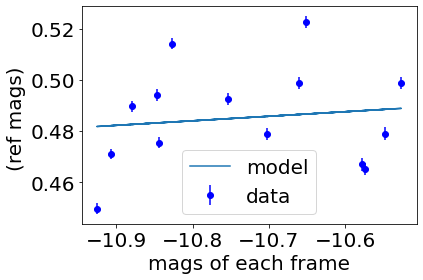

140
yerr: 0.026781146604465414
y_dash_err: 0.034390296973952225
singular matrix
a; 0.02545018893162835
b; 0.7407765160935305


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


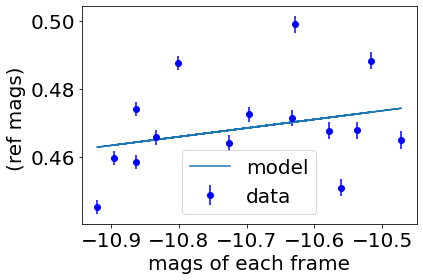

141
yerr: 0.018011760213928966
y_dash_err: 0.02326594305529224
singular matrix
a; -0.00814697284165226
b; 0.3494364333531642


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


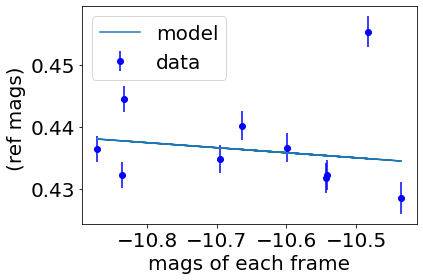

1292/スキップ
142
yerr: 0.007252025986074455
y_dash_err: 0.009405084954949114
143
yerr: 0.009078813563580387
y_dash_err: 0.01173984845301273
144
yerr: 0.0075019789663417265
y_dash_err: 0.009711418589888544
145
yerr: 0.007503544903820754
y_dash_err: 0.00972819478104731
146
yerr: 0.012944409942258843
y_dash_err: 0.016764795059981488
147
yerr: 0.009386927131519765
y_dash_err: 0.01213337648308311
148
yerr: 0.008664771118522823
y_dash_err: 0.01121178563439069
149
yerr: 0.01847651363756163
y_dash_err: 0.023925564128566546
singular matrix
a; -0.019245721961717064
b; 0.21963193552388716


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


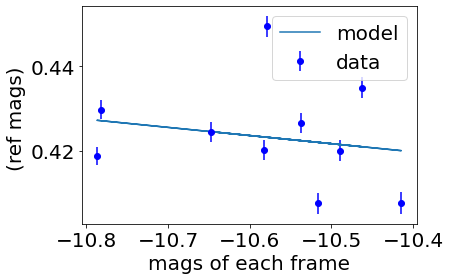

150
yerr: 0.005254485129213083
y_dash_err: 0.00678122605710411
151
yerr: 0.010762505638479053
y_dash_err: 0.013901165665394094
152
yerr: 0.010310132141188167
y_dash_err: 0.013350921249835526
153
yerr: 0.011409341036468129
y_dash_err: 0.01475515764384067
154
yerr: 0.0037881909451158245
y_dash_err: 0.004896749228370797
155
yerr: 0.0090965631468204
y_dash_err: 0.011747644247772285
156
yerr: 0.0032376984837776523
y_dash_err: 0.004194704258832175
157
yerr: 0.009459189910512047
y_dash_err: 0.012277458024342998
158
yerr: 0.01320558377803589
y_dash_err: 0.017133919832509614
159
yerr: 0.01624455372791459
y_dash_err: 0.0211031729954936
160
yerr: 0.009401864559866933
y_dash_err: 0.012166611362561511
161
yerr: 0.01768392258538293
y_dash_err: 0.02301508830576492
singular matrix
a; -0.02889031922542989
b; 0.08950556194867927


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


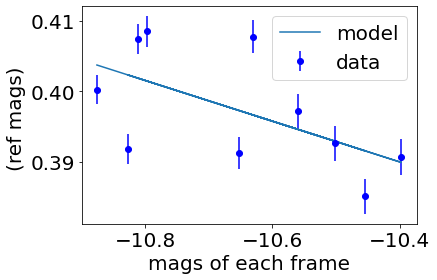

162
yerr: 0.006764126975701384
y_dash_err: 0.008808625171929702
163
yerr: 0.008654958765689431
y_dash_err: 0.01125118200499002
164
yerr: 0.005242781869518043
y_dash_err: 0.0068177298022580705
165
yerr: 0.010960530159148966
y_dash_err: 0.014208289045715507
166
yerr: 0.007534010605221054
y_dash_err: 0.009741859625701031
167
yerr: 0.005818245845041787
y_dash_err: 0.0075548834847875635
168
yerr: 0.005744498220311523
y_dash_err: 0.007470344239379434
169
yerr: 0.0
y_dash_err: 0.0
170
yerr: 0.0055258922306483
y_dash_err: 0.00718673429635455
171
yerr: 0.010296655882474939
y_dash_err: 0.01337605770701026
172
yerr: 0.009102331924651525
y_dash_err: 0.011862245597475098
173
yerr: 0.014890882836814855
y_dash_err: 0.01935237609465966
174
yerr: 0.00554863932726693
y_dash_err: 0.007186207782369452
175
yerr: 0.015932855174015083
y_dash_err: 0.020752587301857188
176
yerr: 0.011307264121989711
y_dash_err: 0.014626707154290002
177
yerr: 0.007221732551395983
y_dash_err: 0.009374603545567696
178
yerr: 0.014

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


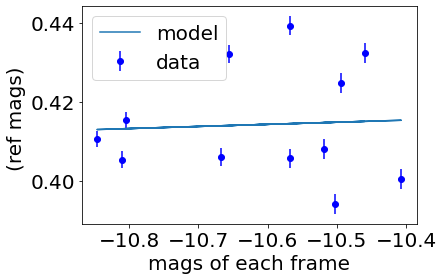

186
yerr: 0.023392288620157096
y_dash_err: 0.03024847552153322
singular matrix
a; 0.018009473896184344
b; 0.6228921616445673


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


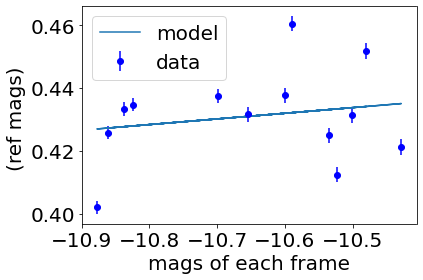

187
yerr: 0.012014172129104432
y_dash_err: 0.015678406812898015
188
yerr: 0.018352419388659443
y_dash_err: 0.02385983604514015
singular matrix
a; -0.026306228078706303
b; 0.12463482838742333


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


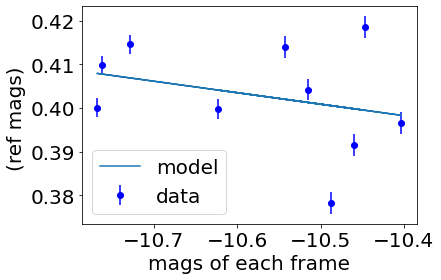

189
yerr: 0.012868324235603126
y_dash_err: 0.016755133681627253
980/スキップ
190
yerr: 0.027741765747534897
y_dash_err: 0.03632483692996198


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.21402352344335013
b; 2.645030457974364


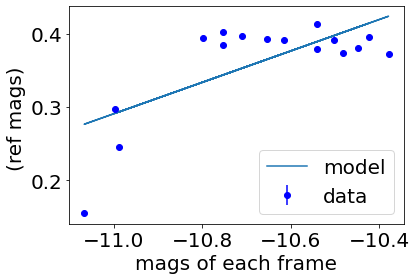

191
yerr: 0.017646967822612
y_dash_err: 0.02289031977275058
singular matrix
a; -0.01970457238385
b; 0.20527449481999668


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


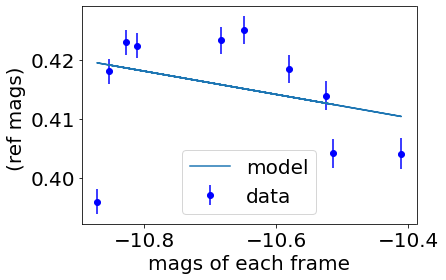

192
yerr: 0.01616134463864961
y_dash_err: 0.02090261563944706
193
yerr: 0.013175118076635592
y_dash_err: 0.017142758218343275
194
yerr: 0.02319277675699186
y_dash_err: 0.030265533249253355
singular matrix
a; -0.04232000568882044
b; -0.05241389553487982


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


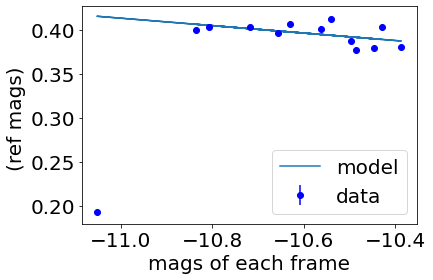

195
yerr: 0.007014689565269433
y_dash_err: 0.009073321618638342
196
yerr: 0.005529320840859317
y_dash_err: 0.007157128075116821
197
yerr: 0.009315169136483623
y_dash_err: 0.012062553936658445
198
yerr: 0.0075758076828130365
y_dash_err: 0.009818059487080482
199
yerr: 0.01859144795260412
y_dash_err: 0.02414660452436193
singular matrix
a; -0.05233287363062252
b; -0.14502333890401833


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


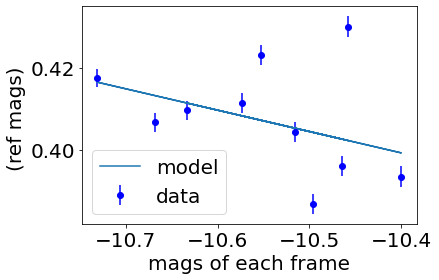

200
yerr: 0.007534010605221054
y_dash_err: 0.009760339396876287
201
yerr: 0.010841916265409398
y_dash_err: 0.014068587832221018
202
yerr: 0.006997894483329047
y_dash_err: 0.009090651996246275
203
yerr: 0.0107081145808691
y_dash_err: 0.013917545568595455
204
yerr: 0.00878616825605485
y_dash_err: 0.011476248097236758
205
yerr: 0.0036425100029492887
y_dash_err: 0.004737166088753969
206
yerr: 0.005329390506490467
y_dash_err: 0.006908407988531947
207
yerr: 0.012944409942258843
y_dash_err: 0.016838533545672524
208
yerr: 0.011837821038233763
y_dash_err: 0.015338386137243074
209
yerr: 0.01623265700052523
y_dash_err: 0.021060078036481324
210
yerr: 0.023392288620157096
y_dash_err: 0.030245476961658625
singular matrix
a; 0.008324556087798597
b; 0.5209855858799648


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


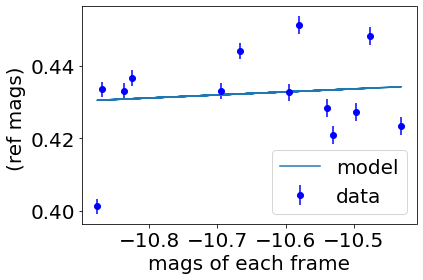

211
yerr: 0.01011402627458494
y_dash_err: 0.013101066754137324
212
yerr: 0.014266187033784156
y_dash_err: 0.01850263277758535
213
yerr: 0.011257251842001515
y_dash_err: 0.014534858441655356
214
yerr: 0.014919622397189577
y_dash_err: 0.019325028041876573
215
yerr: 0.013878637429734945
y_dash_err: 0.017990114786308402
216
yerr: 0.01847651363756163
y_dash_err: 0.02391804591876762
singular matrix
a; -0.024545819288576663
b; 0.1650349488380728


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


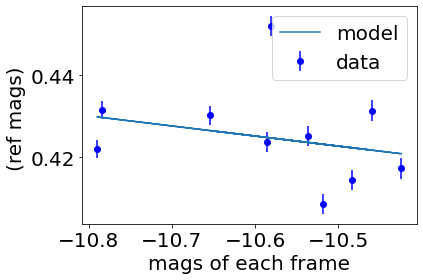

217
yerr: 0.014753272400781167
y_dash_err: 0.019148214572170773
218
yerr: 0.0036409440654702604
y_dash_err: 0.004730492465340129
219
yerr: 0.008552570303416919
y_dash_err: 0.011103104468715538
220
yerr: 0.010310132141188167
y_dash_err: 0.01332620322953998
221
yerr: 0.008903779714495857
y_dash_err: 0.01165052593527257
222
yerr: 0.006930727641822712
y_dash_err: 0.008977262968311306
223
yerr: 0.009459189910512047
y_dash_err: 0.012259637559582362
224
yerr: 0.011902469602300474
y_dash_err: 0.015417165273336402
225
yerr: 0.00999889623865101
y_dash_err: 0.013036049862764616
226
yerr: 0.005744498220311523
y_dash_err: 0.007457631262873471
227
yerr: 0.008783228379577438
y_dash_err: 0.011395352130245355
228
yerr: 0.003661466886213438
y_dash_err: 0.004734463676660423
229
yerr: 0.005818245845041787
y_dash_err: 0.007511741272047033
230
yerr: 0.008521688813472632
y_dash_err: 0.01104729610044254
231
yerr: 0.005764358772550296
y_dash_err: 0.0074334385948233925
232
yerr: 0.011837821038233763
y_dash_err:

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


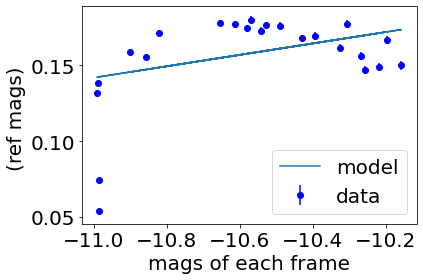

241
yerr: 0.011321132493142882
y_dash_err: 0.014621041527698893
242
yerr: 0.018353426747570456
y_dash_err: 0.02367820294122307
singular matrix
a; 0.0897769422322485
b; 1.3948219256016818


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


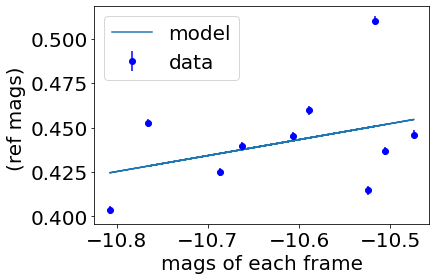

243
yerr: 0.021600350635609337
y_dash_err: 0.028113126734429242
singular matrix
a; 0.017222157494950218
b; 0.5907046829015093


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


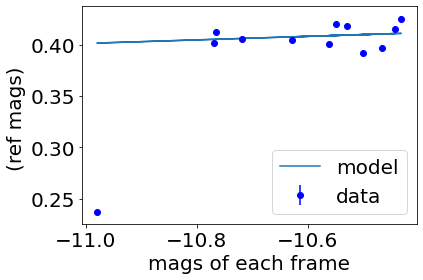

244
yerr: 0.016404087452625067
y_dash_err: 0.021221740932389044
245
yerr: 0.016833886114832875
y_dash_err: 0.021604946862722
246
yerr: 0.0194112262031775
y_dash_err: 0.025823915073035265
singular matrix
a; -0.005586193092396187
b; 0.22612380182234865


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


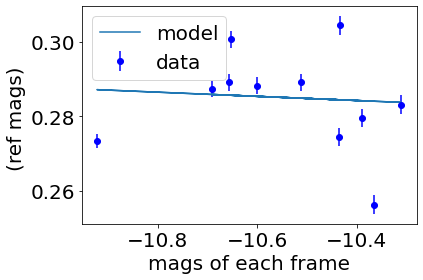

247
yerr: 0.005234702755825682
y_dash_err: 0.006866853792223189
19/スキップ
248
yerr: 0.007800075997869152
y_dash_err: 0.010608164765112251
249
yerr: 0.015526878035806591
y_dash_err: 0.02108527882800554
250
yerr: 0.007134203301682069
y_dash_err: 0.009588623738052216
251
yerr: 0.007123003438058026
y_dash_err: 0.009188134578349976
252
yerr: 0.0037683303928770515
y_dash_err: 0.004912581664854776
253
yerr: 0.012382804806085146
y_dash_err: 0.016007439504021663
254
yerr: 0.0038420780176073163
y_dash_err: 0.004963368525398501
255
yerr: 0.012590004380582182
y_dash_err: 0.01660231605398767
256
yerr: 0.021668646825712727
y_dash_err: 0.028614727940296316
singular matrix
a; -0.019104188624890453
b; 0.1201567194857934


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


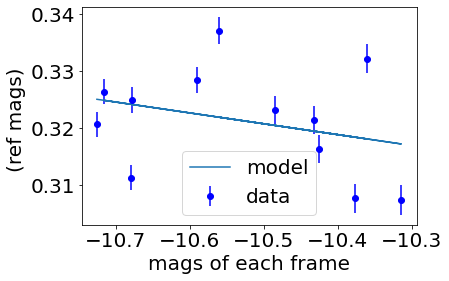

257
yerr: 0.0
y_dash_err: 0.0
258
yerr: 0.0090965631468204
y_dash_err: 0.011970437012395184
259
yerr: 0.012332490466413899
y_dash_err: 0.016261900455320444
260
yerr: 0.011700175658031688
y_dash_err: 0.02122154233819375
261
yerr: 0.016467471223481404
y_dash_err: 0.0215071009481953
262
yerr: 0.006004749598899156
y_dash_err: 0.00793929752862078
263
yerr: 0.0
y_dash_err: 0.0
264
yerr: 0.010845966893210237
y_dash_err: 0.014124278605874018
26/スキップ
265
yerr:

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


 0.010195056097017995
y_dash_err: 0.013411165645139417
266
yerr: 0.005449910213928972
y_dash_err: 0.007047915130430351
267
yerr: 0.0
y_dash_err: 0.0
268
yerr: 0.0184651768646447
y_dash_err: 0.02451427724239029
singular matrix
a; 0.03587110976018611
b; 0.6780322072365054


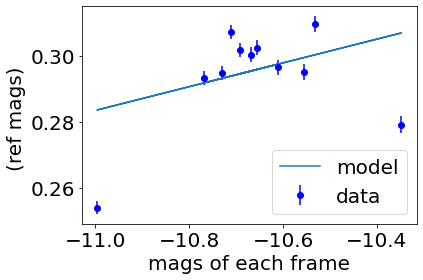

33/スキップ
269
yerr: 0.04088557861358524
y_dash_err: 0.14132412375587958
singular matrix
a; 0.17241645811768985
b; -1.2414315578428101


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


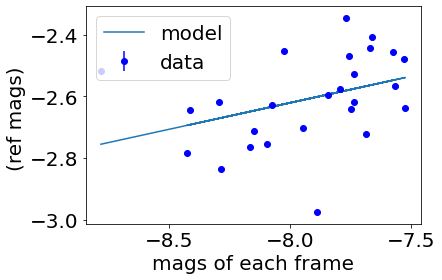

45/スキップ
270
yerr: 0.04511329878485732
y_dash_err: 0.12215702449757093
singular matrix
a; 0.27252257429553006
b; 0.30990618693469046


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


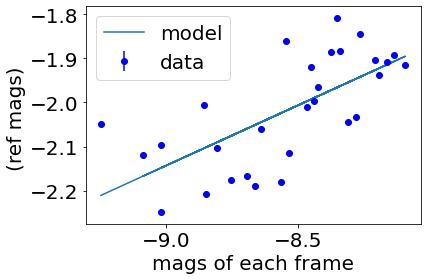

271
yerr: 0.03664185012461067
y_dash_err: 0.04878301535324507
singular matrix
a; 0.1455772359919778
b; 1.8301788576103597


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


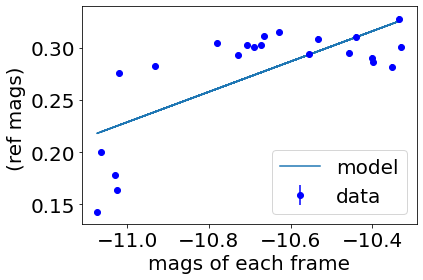

682/スキップ
272
yerr: 0.03797487118554051
y_dash_err: 0.05162181434886042
singular matrix
a; 0.03086712648514054
b; 0.5100003020547712


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


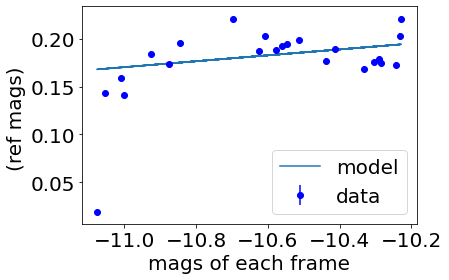

273
yerr: 0.020744957038264813
y_dash_err: 0.027581054841638423
singular matrix
a; -0.02655991612573342
b; 0.00606116728314108


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


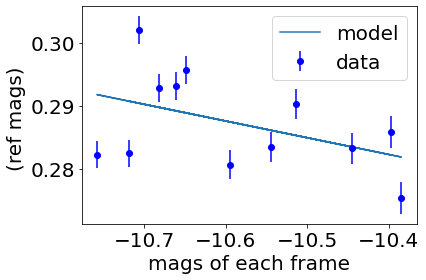

274
yerr: 0.017997811177551098
y_dash_err: 0.0235917076516097
singular matrix
a; -0.02947635864044401
b; 0.048001467149727285


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


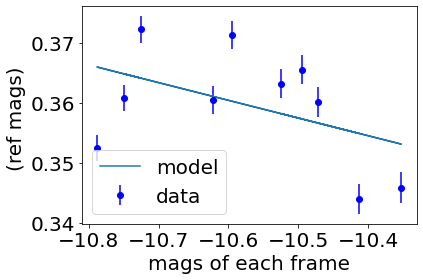

275
yerr: 0.028466445663244383
y_dash_err: 0.037299677390393554
singular matrix
a; -0.0013005330540290135
b; 0.34754829600412107


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


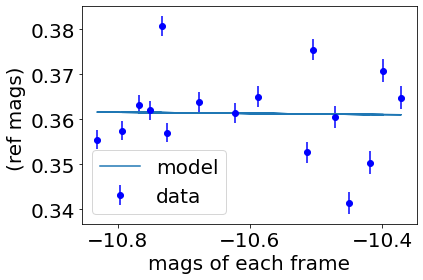

638/スキップ
276
yerr: 0.03411197576575685
y_dash_err: 0.04512230806123099
singular matrix
a; 0.04791498852096232
b; 0.8311764700142423


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


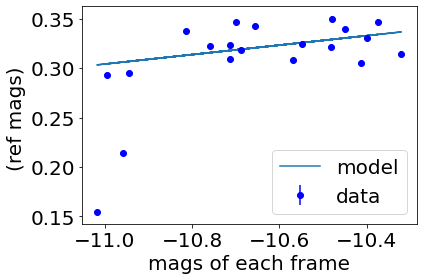

277
yerr: 0.028344199802807755
y_dash_err: 0.03738968773655227
singular matrix
a; 0.0005763378534524054
b; 0.33354104587100386


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


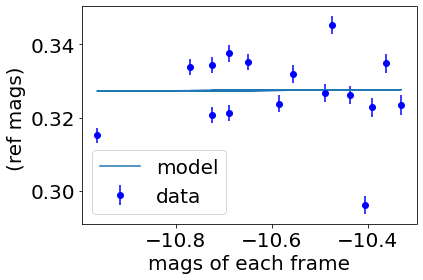

621/スキップ
278
yerr: 0.036663780800693234
y_dash_err: 0.04937491689456078
singular matrix
a; 0.09837343947845072
b; 1.2669590820815082


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


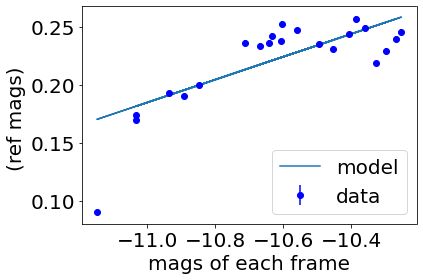

279
yerr: 0.013329678026938074
y_dash_err: 0.01753306744149393
280
yerr: 0.010668176544755478
y_dash_err: 0.014264364597773437
12/スキップ
281
yerr: 0.015377309411623219
y_dash_err: 0.020708989272777555
singular matrix
a; 0.42752848825657014
b; 4.916550666819771


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


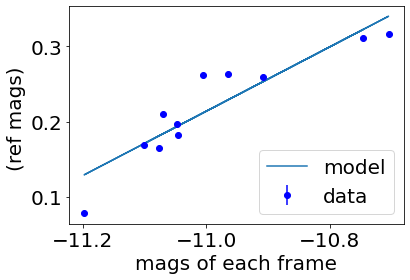

413/スキップ
282
yerr: 0.04291892521976251
y_dash_err: 0.05976751674396332
singular matrix
a; 0.059167508755246456
b; 0.6946343369258274


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


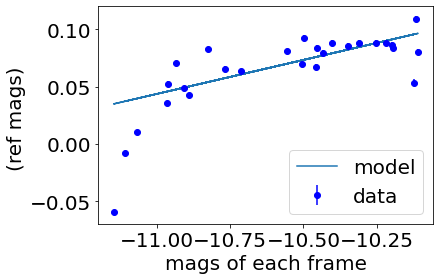

188/スキップ
283
yerr: 0.037119993697254626
y_dash_err: 0.05015438682460545
singular matrix
a; 0.13282853850197524
b; 1.6213691609069818


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


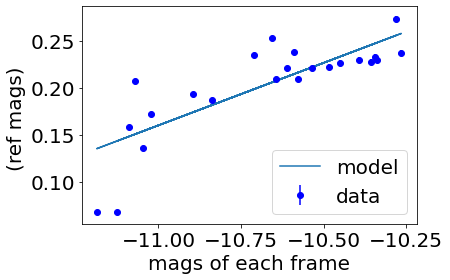

189/スキップ
284
yerr: 0.03806309525488848
y_dash_err: 0.05200736777706132
singular matrix
a; 0.11329067619392941
b; 1.3598433820947804


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


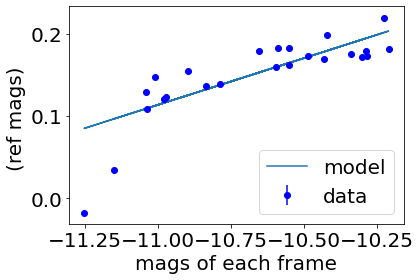

163/スキップ
285
yerr: 0.04291892521976251
y_dash_err: 0.05947995263553756
singular matrix
a; 0.07824836144166974
b; 0.915032880360627


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


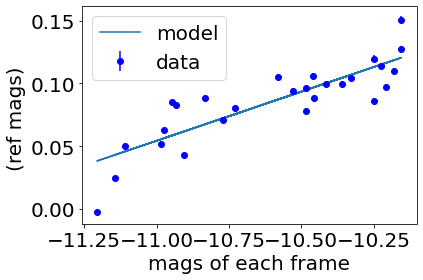

116/スキップ
286
yerr: 0.02990179174175608
y_dash_err: 0.039993315847456815
singular matrix
a; 0.0874101435286777
b; 1.183577915213684


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


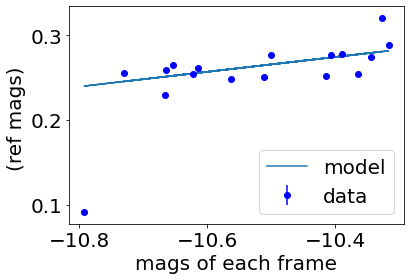

90/スキップ
287
yerr: 0.041782528045721204
y_dash_err: 0.06084263274804869
singular matrix
a; 0.05106823960476553
b; 0.40390735043872783


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


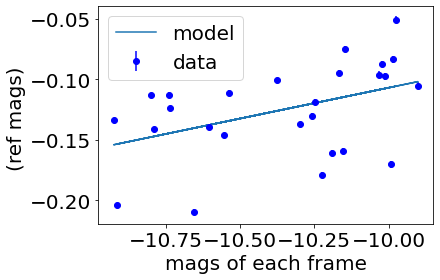

256/スキップ
288
yerr: 0.03137188334243175
y_dash_err: 0.04264899703749988
singular matrix
a; 0.10078688300038538
b; 1.2327487101531558


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


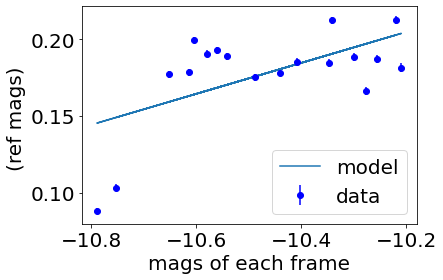

186/スキップ
289
yerr: 0.03938034237609964
y_dash_err: 0.05579866144033349
singular matrix
a; 0.057635526266223605
b; 0.5906445491320502


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


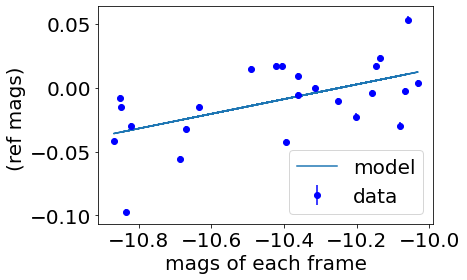

62/スキップ
290
yerr: 0.03648485874201006
y_dash_err: 0.05348606866970516
singular matrix
a; 0.15760182236768217
b; 1.4598988390615497


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


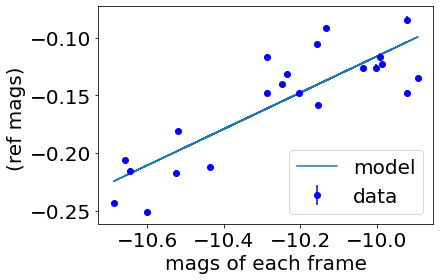

73/スキップ
291
yerr: 0.04056484813091301
y_dash_err: 0.061297889986374185
singular matrix
a; 0.12182567769509829
b; 0.9645761845989211


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


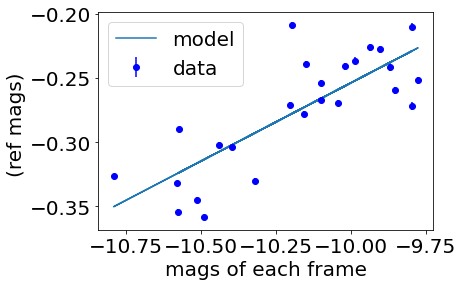

22/スキップ
292
yerr: 0.04511329878485732
y_dash_err: 0.07889968486955762
singular matrix
a; 0.22079962383854676
b; 1.3618338146932178


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


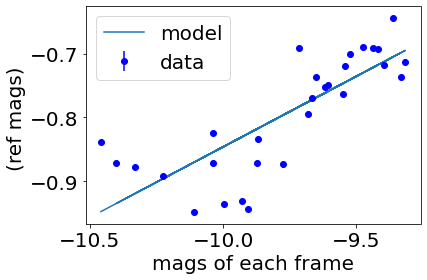

64/スキップ
293
yerr: 0.04170124530495432
y_dash_err: 0.0640089298351192
singular matrix
a; 0.11880807369661835
b; 0.8711846462422131


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


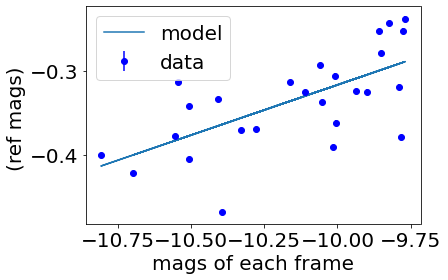

294
yerr: 0.014309312862394927
y_dash_err: 0.018491811600407092
295
yerr: 0.016803420413432576
y_dash_err: 0.021740417371362324
296
yerr: 0.012627078472796451
y_dash_err: 0.016326348260634758
297
yerr: 0.029936537263920062
y_dash_err: 0.03896388341894693
singular matrix
a; 0.12657629337517878
b; 1.7440280850497873


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


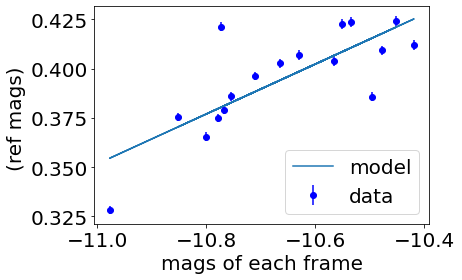

298
yerr: 0.015118121354653607
y_dash_err: 0.019590135931598834
299
yerr: 0.0
y_dash_err: 0.0
300
yerr: 0.0017884433277155344
y_dash_err: 0.0023443578073291597
301
yerr: 0.0
y_dash_err: 0.0
302
yerr: 0.018324938348486974
y_dash_err: 0.023585455036252714
singular matrix
a; 0.13650533371908227
b; 1.906200599972175


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


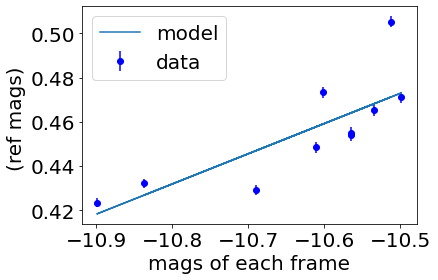

303
yerr: 0.02347872129943969
y_dash_err: 0.0300755521631005
singular matrix
a; 0.1438364181318808
b; 2.0196857022170676


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


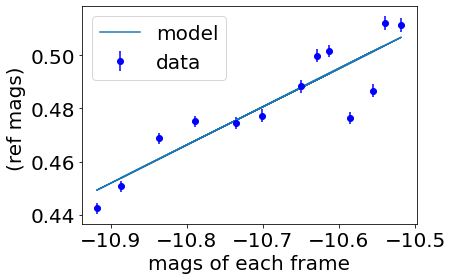

304
yerr: 0.0
y_dash_err: 0.0
305
yerr: 0.01310718509495754
y_dash_err: 0.016705025364404005
306
yerr: 0.0
y_dash_err: 0.0
307
yerr: 0.020194137439219256
y_dash_err: 0.025782648034757747
singular matrix
a; 0.13661754573441803
b; 1.958660492852013


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


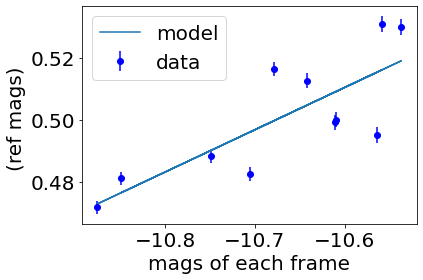

308
yerr: 0.0
y_dash_err: 0.0
309
yerr: 0.013329678026938074
y_dash_err: 0.01706600427086618
1316/スキップ
310
yerr: 0.004441469321035422
y_dash_err: 0.005849786361998339
311
yerr: 0.021479493086156123
y_dash_err: 0.027927854813372607


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.2174106899253797
b; 2.710940218613859


<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


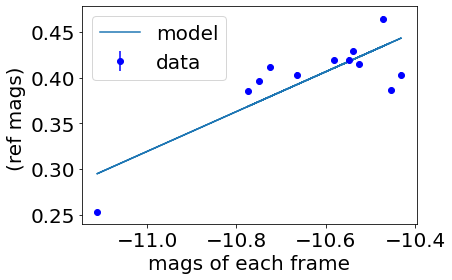

<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


312
yerr: 0.0
y_dash_err: 0.0
313
yerr: 0.01504544278711734
y_dash_err: 0.018912714428324894
5/スキップ
314
yerr: 0.0014353460785116955
y_dash_err: 0.0018997175250206539
315
yerr: 0.0018849481651780399
y_dash_err: 0.0024260717713207474
316
yerr: 0.010554802066129762
y_dash_err: 0.0287769236969101
317
yerr: 0.0016453610226653446
y_dash_err: 0.0021402355990848138
318
yerr: 0.0011845057548133676
y_dash_err: 0.0016680835759481966
319
yerr: 0.0
y_dash_err: 0.0
320
yerr: 0.029936537263920062
y_dash_err: 0.03956087843388437
singular matrix
a; 0.19746759838818392
b; 2.4004707634980527


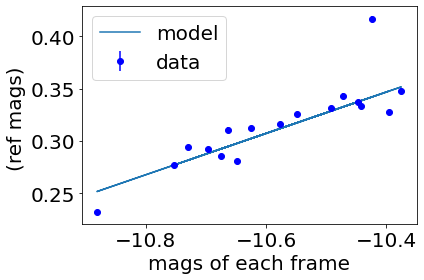

321
yerr: 0.0
y_dash_err: 0.0
322
yerr: 0.0
y_dash_err: 0.0
323
yerr: 0.0
y_dash_err: 0.0
324
yerr: 0.0019203369904699453
y_dash_err: 0.002485801833045692
325
yerr: 0.0
y_dash_err: 0.0
288/スキップ
326
yerr: 0.041782528045721204
y_dash_err: 0.05702201793900551


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.047680655703536606
b; 0.6646806882602698


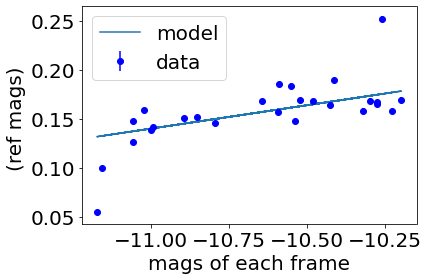

343/スキップ
327
yerr: 0.04049094746829505
y_dash_err: 0.05427788757070055


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


singular matrix
a; 0.10813329252132632
b; 1.4078630594307913


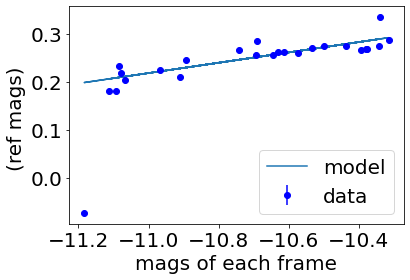

328
yerr: 0.009343403912902205
y_dash_err: 0.012170439836570526
329
yerr: 0.003558041389307093
y_dash_err: 0.004583395042907839
330
yerr: 0.0
y_dash_err: 0.0
331
yerr: 0.023486210718742156
y_dash_err: 0.030290615749285245
singular matrix
a; 0.1247223628787802
b; 1.7729603464636996


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


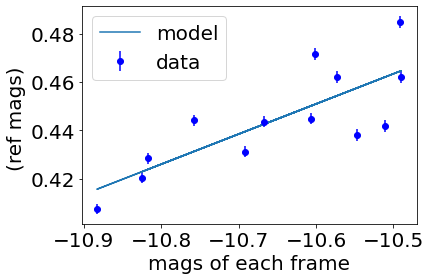

332
yerr: 0.028466445663244383
y_dash_err: 0.0370023347193939
singular matrix
a; 0.10162229009156078
b; 1.4794034163299832


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


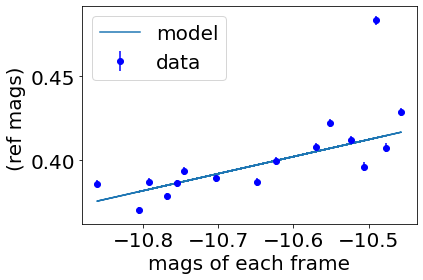

333
yerr: 0.028282180440000523
y_dash_err: 0.036735582572542495
singular matrix
a; 0.08506081365634821
b; 1.3146494430767222


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


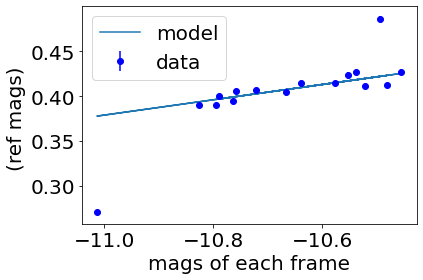

334
yerr: 0.019210882070312515
y_dash_err: 0.027172690878048012
singular matrix
a; 0.022784934040361304
b; 0.2370100730089686


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


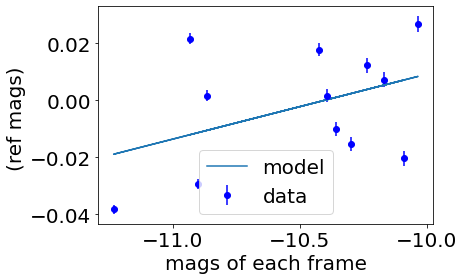

335
yerr: 0.005424329406473943
y_dash_err: 0.006890528752096685
336
yerr: 0.001339964397326658
y_dash_err: 0.0018040117800533003
337
yerr: 0.033849314647674336
y_dash_err: 0.05475259207037486
singular matrix
a; 0.2922888579329844
b; 2.3746161034750375


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


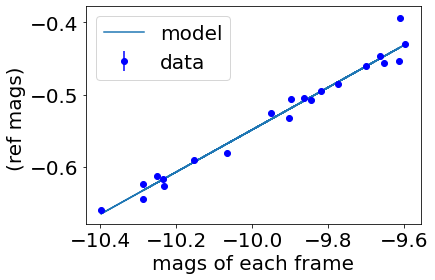

338
yerr: 0.0313446095017885
y_dash_err: 0.040314363885650024
singular matrix
a; 0.23478535213901314
b; 2.980217512637089


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


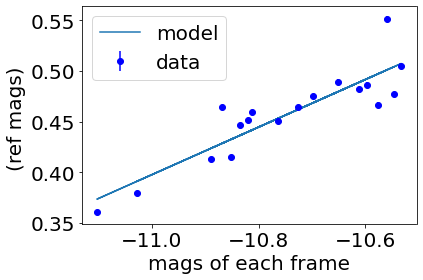

184/スキップ
339
yerr: 0.046223903877052726
y_dash_err: 0.06602107867203619
singular matrix
a; 0.005078324297538165
b; 0.008424499017690532


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


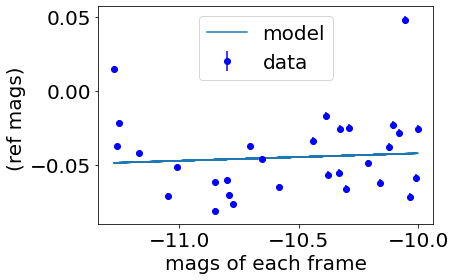

285/スキップ
340
yerr: 0.04059802229090783
y_dash_err: 0.05444254362267041
singular matrix
a; 0.10883218286492626
b; 1.4073125405727127


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


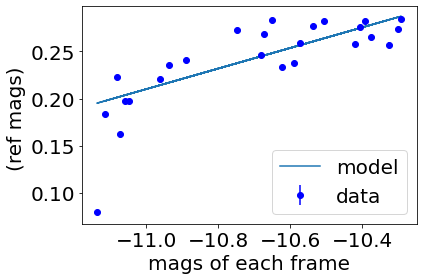

341
yerr: 0.0
y_dash_err: 0.0
342
yerr: 0.01859144795260412
y_dash_err: 0.023944120876836127
singular matrix
a; 0.1519542605270601
b; 2.06003499301652


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


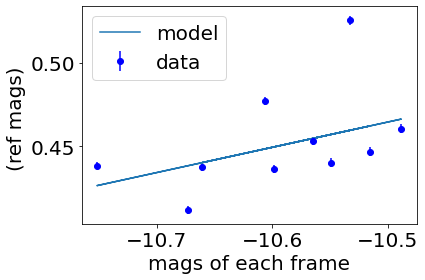

343
yerr: 0.0
y_dash_err: 0.0
344
yerr: 0.01845572877642708
y_dash_err: 0.023890447356299156
singular matrix
a; 0.11275223074696786
b; 1.6119068537706194


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


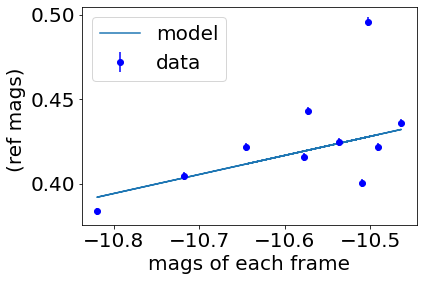

345
yerr: 0.0
y_dash_err: 0.0
346
yerr: 0.0
y_dash_err: 0.0
557/スキップ
347
yerr: 0.041782528045721204
y_dash_err: 0.05653426997563802
singular matrix
a; 0.10245723488558889
b; 1.292669873010579


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


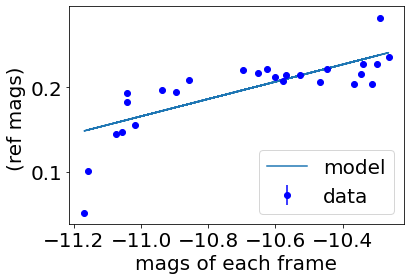

348
yerr: 0.026874108202132076
y_dash_err: 0.035147559987461476
singular matrix
a; 0.12557407304236506
b; 1.6954440771446462


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


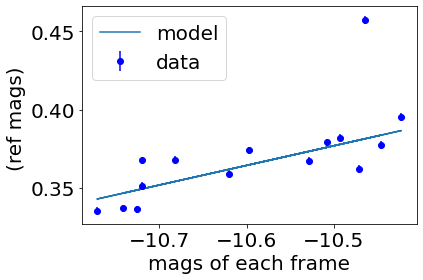

349
yerr: 0.023606904517872524
y_dash_err: 0.030927911773582267
singular matrix
a; 0.1187971263628111
b; 1.6099630322657668


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


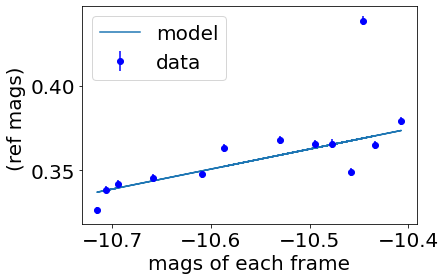

808/スキップ
350
yerr: 0.03534911903286387
y_dash_err: 0.046484556514192636
singular matrix
a; 0.22932462875758813
b; 2.79333323713063


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


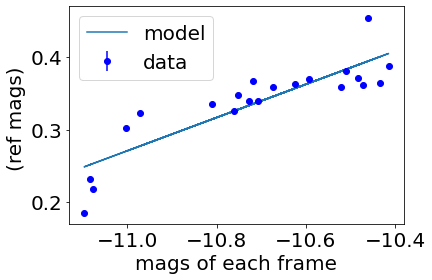

351
yerr: 0.025252265540537867
y_dash_err: 0.032864809228017024
singular matrix
a; 0.11650277529206642
b; 1.6282901890280894


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


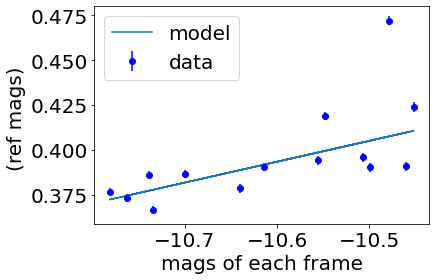

486/スキップ
352
yerr: 0.041782528045721204
y_dash_err: 0.0571604367382457
singular matrix
a; 0.0632438462984277
b; 0.8194762760330733


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


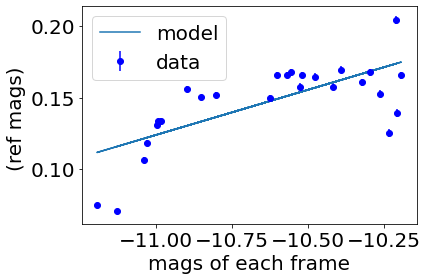

353
yerr: 0.028466445663244383
y_dash_err: 0.03725064835960873
singular matrix
a; 0.08044992236809982
b; 1.2161209949921867


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


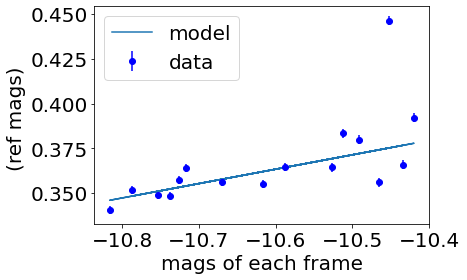

354
yerr: 0.016763482377318954
y_dash_err: 0.021708715590939277
459/スキップ
355
yerr: 0.03673723180579571
y_dash_err: 0.048751335341397764
singular matrix
a; 0.14979400514416927
b; 1.8928997395610359


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


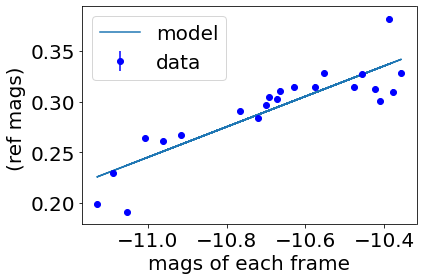

356
yerr: 0.0
y_dash_err: 0.0
357
yerr: 0.0012176799148081918
y_dash_err: 0.0016943643999689617
358
yerr: 0.005608189401958501
y_dash_err: 0.007318886692687874
359
yerr: 0.02987451790111283
y_dash_err: 0.03882300657986302
singular matrix
a; 0.1707895196808793
b; 2.224996808233211


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


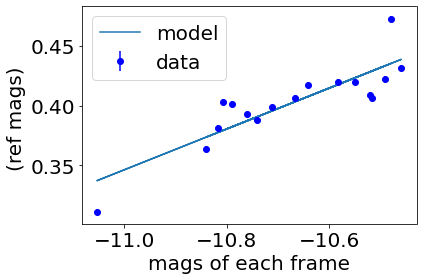

360
yerr: 0.0
y_dash_err: 0.0
361
yerr: 0.007150266030498439
y_dash_err: 0.009160211413542674
362
yerr: 0.0012176799148081918
y_dash_err: 0.0017026406770081972
363
yerr: 0.01847924713749822
y_dash_err: 0.02371176997033775
singular matrix
a; 0.09158616895762499
b; 1.4418212797859484


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


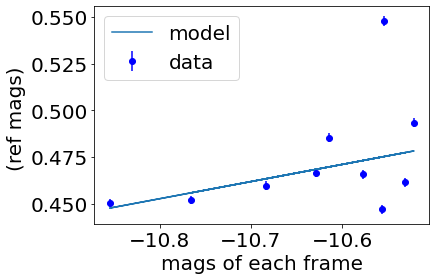

364
yerr: 0.024868520965815256
y_dash_err: 0.031997210189655075
singular matrix
a; 0.28260849976903313
b; 3.480148929915799


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


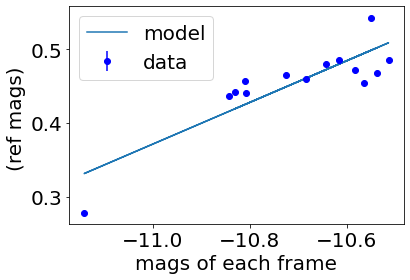

365
yerr: 0.028466445663244383
y_dash_err: 0.03686331980260826
singular matrix
a; 0.11294807799102588
b; 1.6267302481072585


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


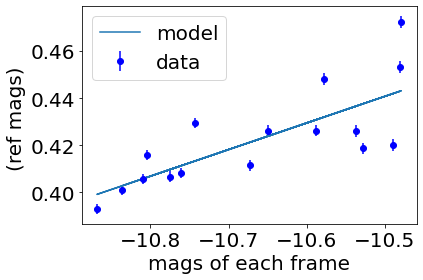

366
yerr: 0.003186528400676285
y_dash_err: 0.004168451015062969
367
yerr: 0.016875683192424856
y_dash_err: 0.021571059976041553
211/スキップ
368
yerr: 0.029345112693498644
y_dash_err: 0.053707272029512594
singular matrix
a; 0.0282095506418887
b; -0.6602940834892126


<ipython-input-29-5237a995ea0e>:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)
<ipython-input-29-5237a995ea0e>:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_lst = np.linalg.lstsq(A, b)


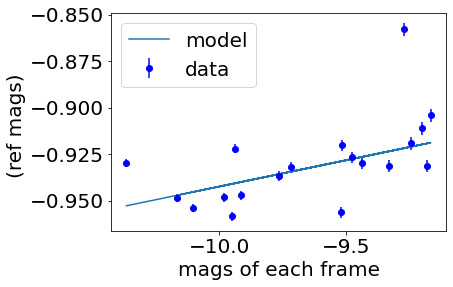

369
yerr: 0.0
y_dash_err: 0.0
370
yerr: 0.007658104854123237
y_dash_err: 0.009860279367457907
371
yerr: 0.01313491729642125
y_dash_err: 0.016608232256077615
372
yerr: 0.011294206604772448
y_dash_err: 0.014390397451125756


In [30]:
#test -- 1 image (id=7)
#sigmas = []
#zero_mag = []
rms = []
cal_err = []
slope = []
intercept = []
sig_a = []
sig_b = []
#reduced_chi = []
rms_sum = 0
#pdf = PdfPages('0mag_match linearfit_-10mag.pdf')
for i in range(len(phot_df)):
    for j in range(len(phot_df[i])):
        if j == target[i]:
            print(f'{j}/スキップ')
            continue
    
    print(i)

    x     = pd.array(phot_df[i]['mag'][sep_constraints[i]])  #each
    xerr  = pd.array(phot_df[i]['mag_err'][sep_constraints[i]]) 

    y     = pd.array(phot_cut_df0['mag'].iloc[idxs[i][sep_constraints[i]]]) #ref
    yerr  = pd.array(phot_cut_df0['mag_err'].iloc[idxs[i][sep_constraints[i]]])
    
    y_cor = y - x
    yerr_cor = np.sqrt(xerr**2 + yerr**2)
    print('yerr:', np.sum(yerr))
    print('y_dash_err:', np.sum(yerr_cor))
    
    
    
    if len(y)<10:
        #zero_mag.append('nan')
        #rms.append('1e3')
        #sigmas.append('1e3')
        #cal_err.append('1e3')
        #reduced_chi.append('1e3')
        slope.append('100')
        intercept.append('100')
        sig_a.append('100')
        sig_b.append('100')
        
    else:     
        y_slope=[]
        #fit = [a,b], siga=a_err, sigb=b_err
        fit, siga, sigb = _biweight2_withu(x, y_cor, yerr_cor, 10)

        #reduced_chi
        #red_chi = np.sum(((y-(x*fit[0]+fit[1]))/yerr)**2)/(len(x)-2)
        #reduced_chi.append(red_chi)
        #print('reduced chi:', red_chi)
        
        slope.append(fit[0])
        intercept.append(fit[1])
        print('a;', fit[0])
        print('b;', fit[1])
        sig_a.append(siga)
        sig_b.append(sigb)

        
        fig,axes = plt.subplots()
        axes.errorbar(x, y_cor,  yerr=np.sqrt(pd.array(phot_df[i]['mag_err'][sep_constraints[i]])**2+pd.array(phot_cut_df0['mag_err'].iloc[idxs[i][sep_constraints[i]]])**2),fmt='o',color='blue',label='data')

        axes.plot(phot_df[i]['mag'][sep_constraints[i]], fit[0]*phot_df[i]['mag'][sep_constraints[i]]+fit[1], label='model')
        axes.set_xlabel('mags of each frame')
        axes.set_ylabel('(ref mags) ')

        axes.legend()
        plt.show()
        #pdf.savefig(fig)
        

    #print('rms:',rms[i])
#pdf.close()

In [31]:
jd_list      = []
clr_list     = []
magzp_list   = []
seeing_list  = []
airmass_list = []
t_mag        = []
t_umag       = []
df           = []

ucal_array = np.asarray(cal_err, dtype='f8')

for i in range(len(phot_df)):
    if not pd.array(phot_df[i]['mag'][(phot_df[i]['dec']>-2.145) & (phot_df[i]['dec']<-2.14) & (phot_df[i]['ra']>303.166) & (phot_df[i]['ra']<303.168)]):
        t_mag.append('0')
        t_umag.append('0')
    else:
        t_mag.append(pd.array(phot_df[i]['mag'][(phot_df[i]['dec']>-2.145) & (phot_df[i]['dec']<-2.14) & (phot_df[i]['ra']>303.166) & (phot_df[i]['ra']<303.168)]))
        t_umag.append(pd.array(phot_df[i]['mag_err'][(phot_df[i]['dec']>-2.145) & (phot_df[i]['dec']<-2.14) & (phot_df[i]['ra']>303.166) & (phot_df[i]['ra']<303.168)]))#+ucal_array[i])
t_mag   = list(itertools.chain.from_iterable(t_mag))
t_umag = list(itertools.chain.from_iterable(t_umag))
                
for i in tqdm(range(len(t_mag))):
    jd_list.append(hdu_list[i][0].header['OBSJD'])
    clr_list.append(hdu_list[i][0].header['CLRCOEFF'])
    magzp_list.append(hdu_list[i][0].header['MAGZP'])
    seeing_list.append(hdu_list[i][0].header['SEEING'])
    airmass_list.append(hdu_list[i][0].header['AIRMASS'])
    
    
listData = [jd_list,t_mag,t_umag,clr_list,magzp_list,seeing_list,airmass_list]
df = pd.DataFrame(listData,dtype='float64').T
df.columns = ['JD','tmag0','tmag_err','color_coef','magzp','seeing','airmass']
slope_arr = np.array(slope, dtype=float64)
inter_arr  = np.array(intercept, dtype=float64)
#redchi_arr = np.array(reduced_chi, dtype=float64)
sig_a_arr = np.array(sig_a, dtype=float64) #slope err
sig_b_arr = np.array(sig_b, dtype=float64) #intercept err

df['tmag'] = (slope_arr+1)*df['tmag0']+inter_arr
df['tmag_err_corr'] = np.sqrt((sig_a_arr*df['tmag0'])**2 + (slope_arr*df['tmag_err'])**2 + df['tmag_err']**2 + sig_b_arr**2)

100%|██████████| 373/373 [00:00<00:00, 15777.44it/s]


In [32]:
df.to_csv('lc_wasp80_220222.csv',index=False)

# Dataframe

In [33]:
print('not saturate:', len(df[df['tmag0']!=0]))

df = df[(df['tmag0']!=0) & (df['tmag']>-15)& (df['tmag']<10)]
df = df.astype({'JD': 'float64', "tmag": 'float64', 'tmag_err_corr': 'float64'})

not saturate: 83


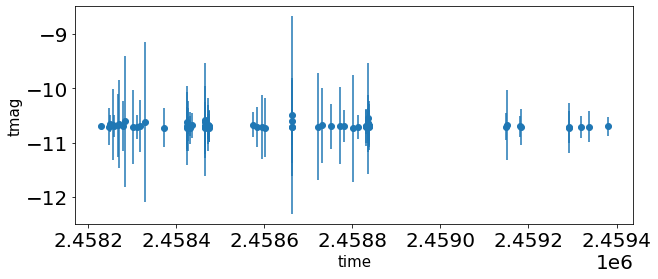

In [39]:
time      = df['JD']
tmag      = df['tmag']
utmag     = df['tmag_err']
utmag_red = df['tmag_err_corr']
#zmag  = df['zeromag']
zmag_inst = df['magzp']
airmass   = df['airmass']
seeing    = df['seeing']
color     = df['color_coef']


plt.figure(figsize=(10,4))
plt.errorbar(time,tmag, yerr=utmag_red, fmt='o')
#plt.errorbar(time,tmag+0.15, yerr=utmag, fmt='o')
#plt.ylim(-11.5,-10.)
plt.xlabel('time',size=15)
plt.ylabel('tmag',size=15)
#plt.savefig('lc.png')

Text(0, 0.5, 'tmag')

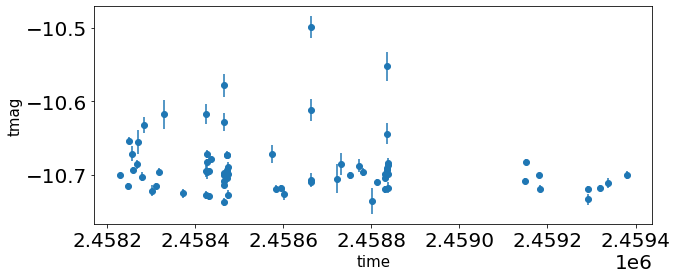

In [49]:
time      = df['JD']
tmag      = df['tmag']
utmag     = df['tmag_err']
utmag_red = df['tmag_err_corr']
#zmag  = df['zeromag']
zmag_inst = df['magzp']
airmass   = df['airmass']
seeing    = df['seeing']
color     = df['color_coef']


plt.figure(figsize=(10,4))
plt.errorbar(time,tmag, yerr=utmag_red, fmt='o')
#plt.errorbar(time,tmag+0.15, yerr=utmag, fmt='o')
#plt.ylim(-11.5,-10.)
plt.xlabel('time',size=15)
plt.ylabel('tmag',size=15)

In [36]:
gls = pyPeriod.Gls((time, tmag, utmag_red), Pbeg=1, Pend=50)


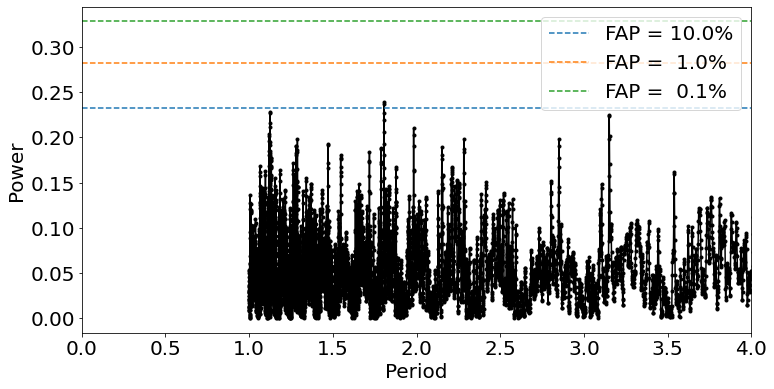

In [38]:
# Define FAP levels of 10%, 5%, and 1%
fapLevels = np.array([0.1, 0.01, 0.001])
# Obtain the associated power thresholds
plevels = gls.powerLevel(fapLevels)

# and plot power vs. frequency.
plt.figure(figsize=(12,6))
plt.rcParams['font.size']=20
plt.xlabel("Period")
plt.ylabel("Power")
plt.plot(1/gls.freq, gls.power, '.-', color='black')
xmin=0
xmax=4
# Add the FAP levels to the plot
for i in range(len(fapLevels)):
    plt.plot([xmin, xmax], [plevels[i]]*2, '--',
             label="FAP = %4.1f%%" % (fapLevels[i]*100))
#plt.axvline(38.324419, linestyle='dotted', color='gray')
plt.legend()
plt.xlim(xmin,xmax)

#plt.savefig('fap.png')
plt.show()

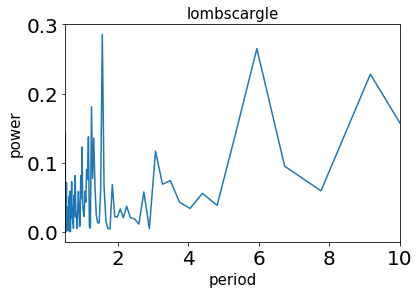

In [39]:
import scipy.signal as signal

f = np.linspace(0.05, 2, 100 )
pgram = signal.lombscargle(time, tmag , f, normalize=True)

plt.plot(1/f, pgram)
plt.title('lombscargle', fontsize=15)
plt.xlabel('period', fontsize=15)
plt.ylabel('power', fontsize=15)
plt.xlim(0.5,10)
plt.show()

No handles with labels found to put in legend.


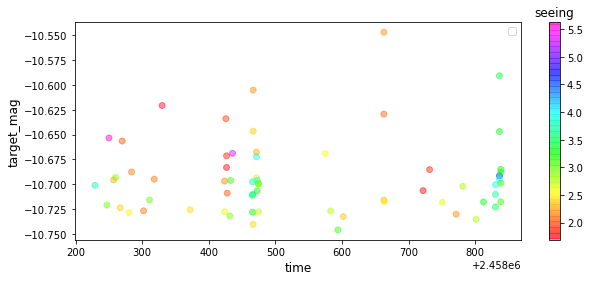

In [64]:
plt.figure(figsize=(10,4))
map1 = plt.scatter(time, tmag, c=seeing, cmap='gist_rainbow', alpha=0.45)
clb2 = plt.colorbar(map1)
clb2.ax.set_title('seeing')
plt.xlabel('time', fontsize=12)
plt.ylabel('target_mag', fontsize=12)

plt.legend()